# Objetivo

O objetivo deste estudo é aplicar técnicas de detecção de anomalias, especificamente o Isolation Forest e o DBSCAN, a um conjunto de dados de contas financeiras. O propósito é identificar contas de transações que se desviam significativamente do comportamento típico, o que pode indicar atividades fraudulentas ou incomuns.

* **CUST_ID** – Identificação única do titular do cartão de crédito.

* **BALANCE** – Saldo atual disponível na conta do usuário para realizar compras.

* **BALANCE_FREQUENCY** – Com que frequência o saldo é atualizado, variando entre 0 e 1. Um valor mais alto indica atualizações mais frequentes.

* **PURCHASES** – Valor total de compras realizadas pelo usuário no cartão de crédito(o que gastou).

* **ONEOFF_PURCHASES** – Valor máximo de compras únicas (não parceladas) feitas pelo usuário.

* **INSTALLMENTS_PURCHASES** – Valor total das compras parceladas realizadas pelo usuário.

* **CASH_ADVANCE** – Quantia de dinheiro retirada antecipadamente pelo usuário por meio do crédito do cartão.O valor sacado não vem da conta bancária, mas sim do limite de crédito disponível no cartão.


* **PURCHASES_FREQUENCY** – Frequência com que o usuário realiza compras no cartão, variando entre 0 e 1.

* **ONEOFF_PURCHASES_FREQUENCY** – Frequência de compras únicas (não parceladas), variando entre 0 e 1 .

* **PURCHASES_INSTALLMENTS_FREQUENCY** – Frequência de compras parceladas, variando entre 0 e 1.

* **CASH_ADVANCE_FREQUENCY** – Frequência com que o usuário faz adiantamentos de dinheiro no cartão de crédito, variando entre 0 e 1.

* **CASH_ADVANCE_TRX** – Número de transações de adiantamento de dinheiro realizadas pelo usuário.

* **PURCHASES_TRX** – Número total de transações de compras feitas pelo usuário.

* **CREDIT_LIMIT** – Limite total de crédito disponível para o usuário no cartão.

* **PAYMENTS** – Total de pagamentos feitos pelo usuário para quitar faturas. Se for maior que `purchases`, pagou mais do que gastou, talvez incluindo pagamentos de meses anteriores.

* **MINIMUM_PAYMENTS** – Valor mínimo dos pagamentos realizados pelo usuário nas faturas .

* **PRC_FULL_PAYMENT** – Percentual de vezes em que o usuário pagou a fatura integralmente, variando entre 0 e 1. O usuário é um bom pagador se for 1, pois não acumula juros. Se for 0, nunca pagou a fatura inteira de uma vez.

* **TENURE** – Tempo de serviço do cartão de crédito para o usuário, geralmente em meses.

# 1. Bibliotecas

In [75]:
# Obtenção e limpeza dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Transformação e normalização
from sklearn.preprocessing import PowerTransformer, RobustScaler

# Redução de dimensionalidade
from sklearn.decomposition import PCA

# Clusterização e detecção de anomalias
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest

# 2. Obtenção e Limpeza dos Dados

## 2.1 Obtenção dos Dados

In [76]:
# Ler Dataset:
url = "https://raw.githubusercontent.com/devjaynemorais/modelos_descritivos_curso/main/Aula%2005/dados/credit_card.csv"
df_credit_card = pd.read_csv(url)
df_credit_card.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [77]:
df_credit_card.shape

(8950, 18)

## 2.2 Limpeza dos Dados

* Colocamos todas as colunas em minúsculos para facilitar leitura e uso.

* Arredondamos para 3 casas decimais os dados numéricos para maior legibilidade.

* Os dados não estão duplicados.

* Removemos os dados vazios, pois representam apenas 3,51% do total, o que não causa uma perda significativa de informação.

In [78]:
# Colunas em letras minúsculas
df_credit_card.columns = df_credit_card.columns.str.lower()

# Valores com 3 casas decimais
df_credit_card = df_credit_card.round(3)

In [79]:
# Verificação de dados duplicados
df_credit_card.duplicated().sum()

0

In [80]:
# Verificação de valores ausentes
df_credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8950 non-null   object 
 1   balance                           8950 non-null   float64
 2   balance_frequency                 8950 non-null   float64
 3   purchases                         8950 non-null   float64
 4   oneoff_purchases                  8950 non-null   float64
 5   installments_purchases            8950 non-null   float64
 6   cash_advance                      8950 non-null   float64
 7   purchases_frequency               8950 non-null   float64
 8   oneoff_purchases_frequency        8950 non-null   float64
 9   purchases_installments_frequency  8950 non-null   float64
 10  cash_advance_frequency            8950 non-null   float64
 11  cash_advance_trx                  8950 non-null   int64  
 12  purcha

In [81]:
print(f'Os dados vazios correspondem a {(len(df_credit_card[df_credit_card.isnull().any(axis=1)])/len(df_credit_card)*100):.2f}% dos dados totais')

Os dados vazios correspondem a 3.51% dos dados totais


In [82]:
# Eliminação de valores ausentes
df_credit_card = df_credit_card.dropna()
df_credit_card.shape

(8636, 18)

In [83]:
df_credit_card.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8636 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8636 non-null   object 
 1   balance                           8636 non-null   float64
 2   balance_frequency                 8636 non-null   float64
 3   purchases                         8636 non-null   float64
 4   oneoff_purchases                  8636 non-null   float64
 5   installments_purchases            8636 non-null   float64
 6   cash_advance                      8636 non-null   float64
 7   purchases_frequency               8636 non-null   float64
 8   oneoff_purchases_frequency        8636 non-null   float64
 9   purchases_installments_frequency  8636 non-null   float64
 10  cash_advance_frequency            8636 non-null   float64
 11  cash_advance_trx                  8636 non-null   int64  
 12  purchases_t

# 3. Análises Exploratórias

De acordo com as análises exploratórias, os dados apresentam muitos outliers e alta assimetria, o que pode prejudicar a detecção de anomalias. Isso ocorre porque o modelo pode interpretar alguns desses valores discrepantes como ruídos, comprometendo a qualidade dos resultados e dificultando o atingimento do objetivo do projeto. Além disso, os dados numéricos estão em escalas diferentes, tornando necessária a normalização para padronizá-los.

In [84]:
df_credit_card.head(10)

cust_id   balance  balance_frequency  purchases  oneoff_purchases  \
0   C10001    40.901              0.818      95.40              0.00   
1   C10002  3202.467              0.909       0.00              0.00   
2   C10003  2495.149              1.000     773.17            773.17   
4   C10005   817.714              1.000      16.00             16.00   
5   C10006  1809.829              1.000    1333.28              0.00   
6   C10007   627.261              1.000    7091.01           6402.63   
7   C10008  1823.653              1.000     436.20              0.00   
8   C10009  1014.926              1.000     861.49            661.49   
9   C10010   152.226              0.545    1281.60           1281.60   
10  C10011  1293.125              1.000     920.12              0.00   

    installments_purchases  cash_advance  purchases_frequency  \
0                    95.40         0.000                0.167   
1                     0.00      6442.945                0.000   
2                     0.00         0.000                1.000   
4                     0.00         0.000                0.083   
5                  1333.28         0.000                0.667   
6                   688.38         0.000                1.000   
7                   436.20         0.000                1.000   
8                   200.00         0.000                0.333   
9                     0.00         0.000                0.167   
10                  920.12         0.000                1.000   

    oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.000                             0.083   
1                        0.000                             0.000   
2                        1.000                             0.000   
4                        0.083                             0.000   
5                        0.000                             0.583   
6                        1.000                             1.000   
7                        0.000                             1.000   
8                        0.083                             0.250   
9                        0.167                             0.000   
10                       0.000                             1.000   

    cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                     0.00                 0              2        1000.0   
1                     0.25                 4              0        7000.0   
2                     0.00                 0             12        7500.0   
4                     0.00                 0              1        1200.0   
5                     0.00                 0              8        1800.0   
6                     0.00                 0             64       13500.0   
7                     0.00                 0             12        2300.0   
8                     0.00                 0              5        7000.0   
9                     0.00                 0              3       11000.0   
10                    0.00                 0             12        1200.0   

    payments  minimum_payments  prc_full_payment  tenure  
0    201.802           139.510             0.000      12  
1   4103.033          1072.340             0.222      12  
2    622.067           627.285             0.000      12  
4    678.335           244.791             0.000      12  
5   1400.058          2407.246             0.000      12  
6   6354.314           198.066             1.000      12  
7    679.065           532.034             0.000      12  
8    688.279           311.963             0.000      12  
9   1164.771           100.302             0.000      12  
10  1083.301          2172.698             0.000      12

In [85]:
df_credit_card.describe()

balance  balance_frequency     purchases  oneoff_purchases  \
count   8636.000000        8636.000000   8636.000000       8636.000000   
mean    1601.224891           0.895019   1025.433874        604.901438   
std     2095.571306           0.207676   2167.107984       1684.307803   
min        0.000000           0.000000      0.000000          0.000000   
25%      148.095250           0.909000     43.367500          0.000000   
50%      916.855000           1.000000    375.405000         44.995000   
75%     2105.196000           1.000000   1145.980000        599.100000   
max    19043.139000           1.000000  49039.570000      40761.250000   

       installments_purchases  cash_advance  purchases_frequency  \
count             8636.000000   8636.000000          8636.000000   
mean               420.843533    994.175524             0.495988   
std                917.245182   2121.458307             0.401292   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083000   
50%                 94.785000      0.000000             0.500000   
75%                484.147500   1132.385250             0.917000   
max              22500.000000  47137.212000             1.000000   

       oneoff_purchases_frequency  purchases_installments_frequency  \
count                 8636.000000                       8636.000000   
mean                     0.205888                          0.368831   
std                      0.300071                          0.398102   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083000                          0.167000   
75%                      0.333000                          0.750000   
max                      1.000000                          1.000000   

       cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
count             8636.000000       8636.000000    8636.000000   8636.000000   
mean                 0.137591          3.313918      15.033233   4522.091030   
std                  0.201803          6.912506      25.180468   3659.240379   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.250000          4.000000      18.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           payments  minimum_payments  prc_full_payment       tenure  
count   8636.000000       8636.000000       8636.000000  8636.000000  
mean    1784.478094        864.304947          0.159296    11.534391  
std     2909.810087       2372.566353          0.296276     1.310984  
min        0.050000          0.019000          0.000000     6.000000  
25%      418.559500        169.163750          0.000000    12.000000  
50%      896.676000        312.452500          0.000000    12.000000  
75%     1951.142250        825.496000          0.167000    12.000000  
max    50721.483000      76406.208000          1.000000    12.000000

## 3.1 Análise de Outliers

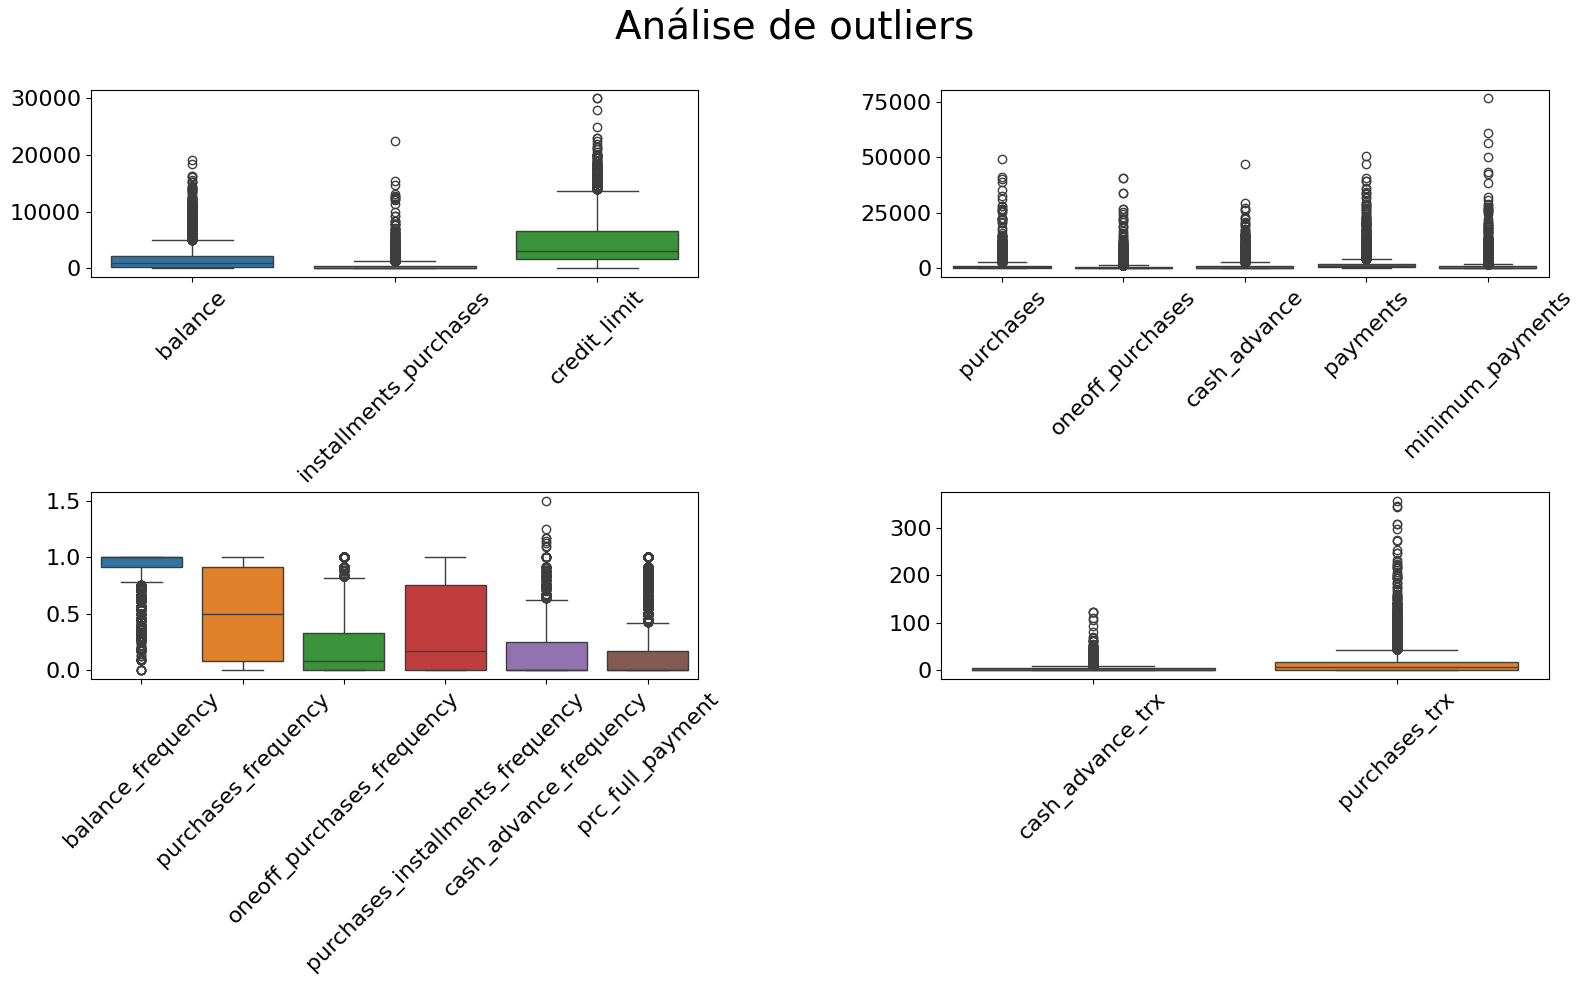

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Primeiro gráfico
sns.boxplot(data=df_credit_card[['balance', 'installments_purchases', 'credit_limit']], orient="v", ax=axes[0, 0])
axes[0, 0].tick_params(axis='x', labelsize=16)
axes[0, 0].tick_params(axis='y', labelsize=16)
axes[0, 0].tick_params(axis='x', rotation=45)

# Segundo gráfico
sns.boxplot(data=df_credit_card[['purchases', 'oneoff_purchases', 'cash_advance', 'payments', 
                            'minimum_payments']], orient="v", ax=axes[0, 1])
axes[0, 1].tick_params(axis='x', labelsize=16)
axes[0, 1].tick_params(axis='y', labelsize=16)
axes[0, 1].tick_params(axis='x', rotation=45)

# Terceiro gráfico
sns.boxplot(data=df_credit_card[['balance_frequency', 'purchases_frequency', 'oneoff_purchases_frequency',
                           'purchases_installments_frequency', 'cash_advance_frequency',
                            'prc_full_payment']], orient="v", ax=axes[1, 0])
axes[1, 0].tick_params(axis='x', labelsize=16)
axes[1, 0].tick_params(axis='y', labelsize=16)
axes[1, 0].tick_params(axis='x', rotation=45)

# Quarto gráfico
sns.boxplot(data=df_credit_card[['cash_advance_trx', 'purchases_trx']], orient="v", ax=axes[1, 1])
axes[1, 1].tick_params(axis='x', labelsize=16)
axes[1, 1].tick_params(axis='y', labelsize=16)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Análise de outliers', fontsize=28)
# Ajustar o layout para que os gráficos não fiquem sobrepostos
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, top=0.9)

plt.show()

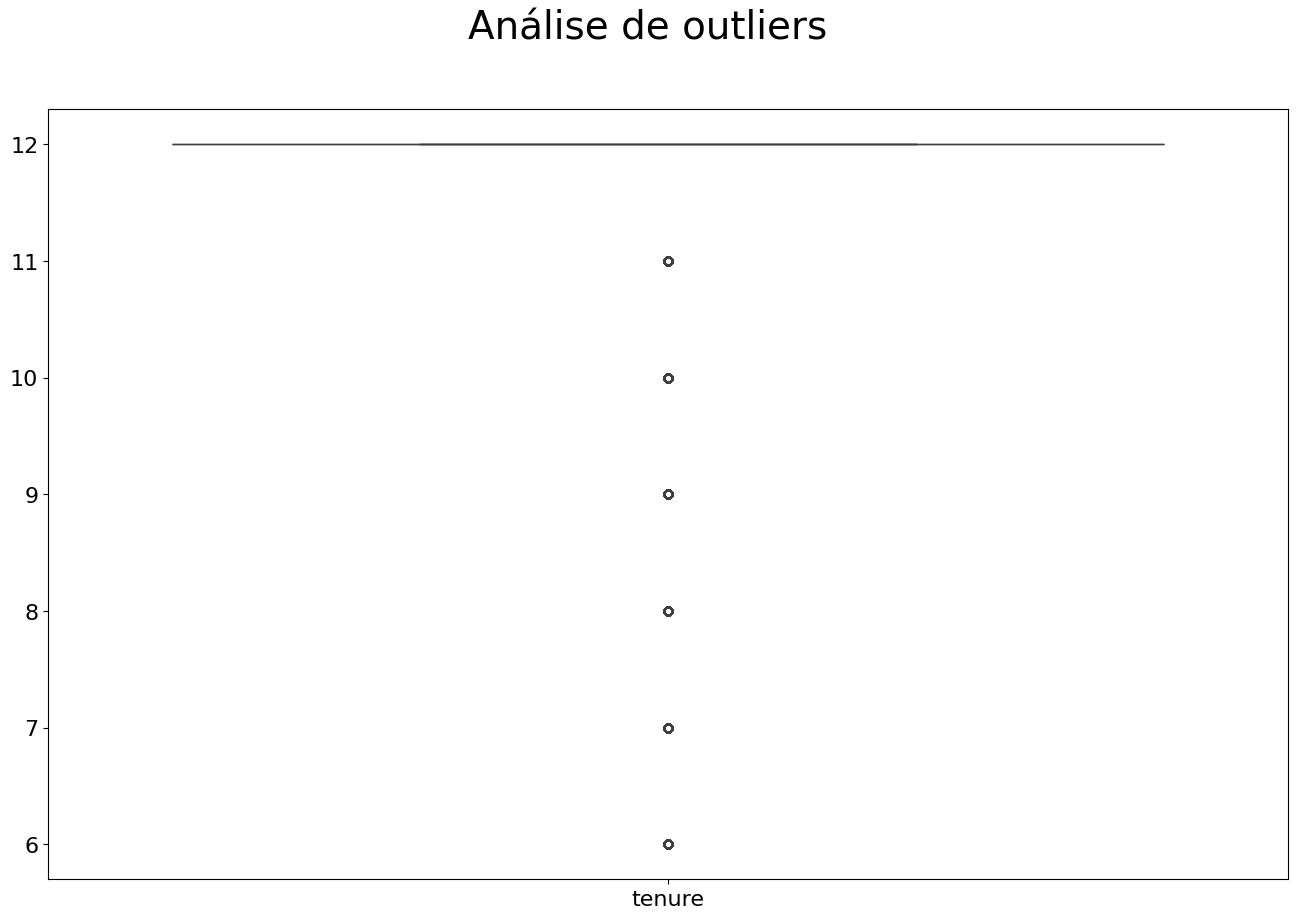

In [87]:
fig, axes = plt.subplots(1, 1, figsize=(16, 10))

sns.boxplot(data=df_credit_card[['tenure']], orient="v")
axes.tick_params(axis='x', labelsize=16)
axes.tick_params(axis='y', labelsize=16)
plt.suptitle('Análise de outliers', fontsize=28)

plt.show()

## 3.2 Análise de Distribuições

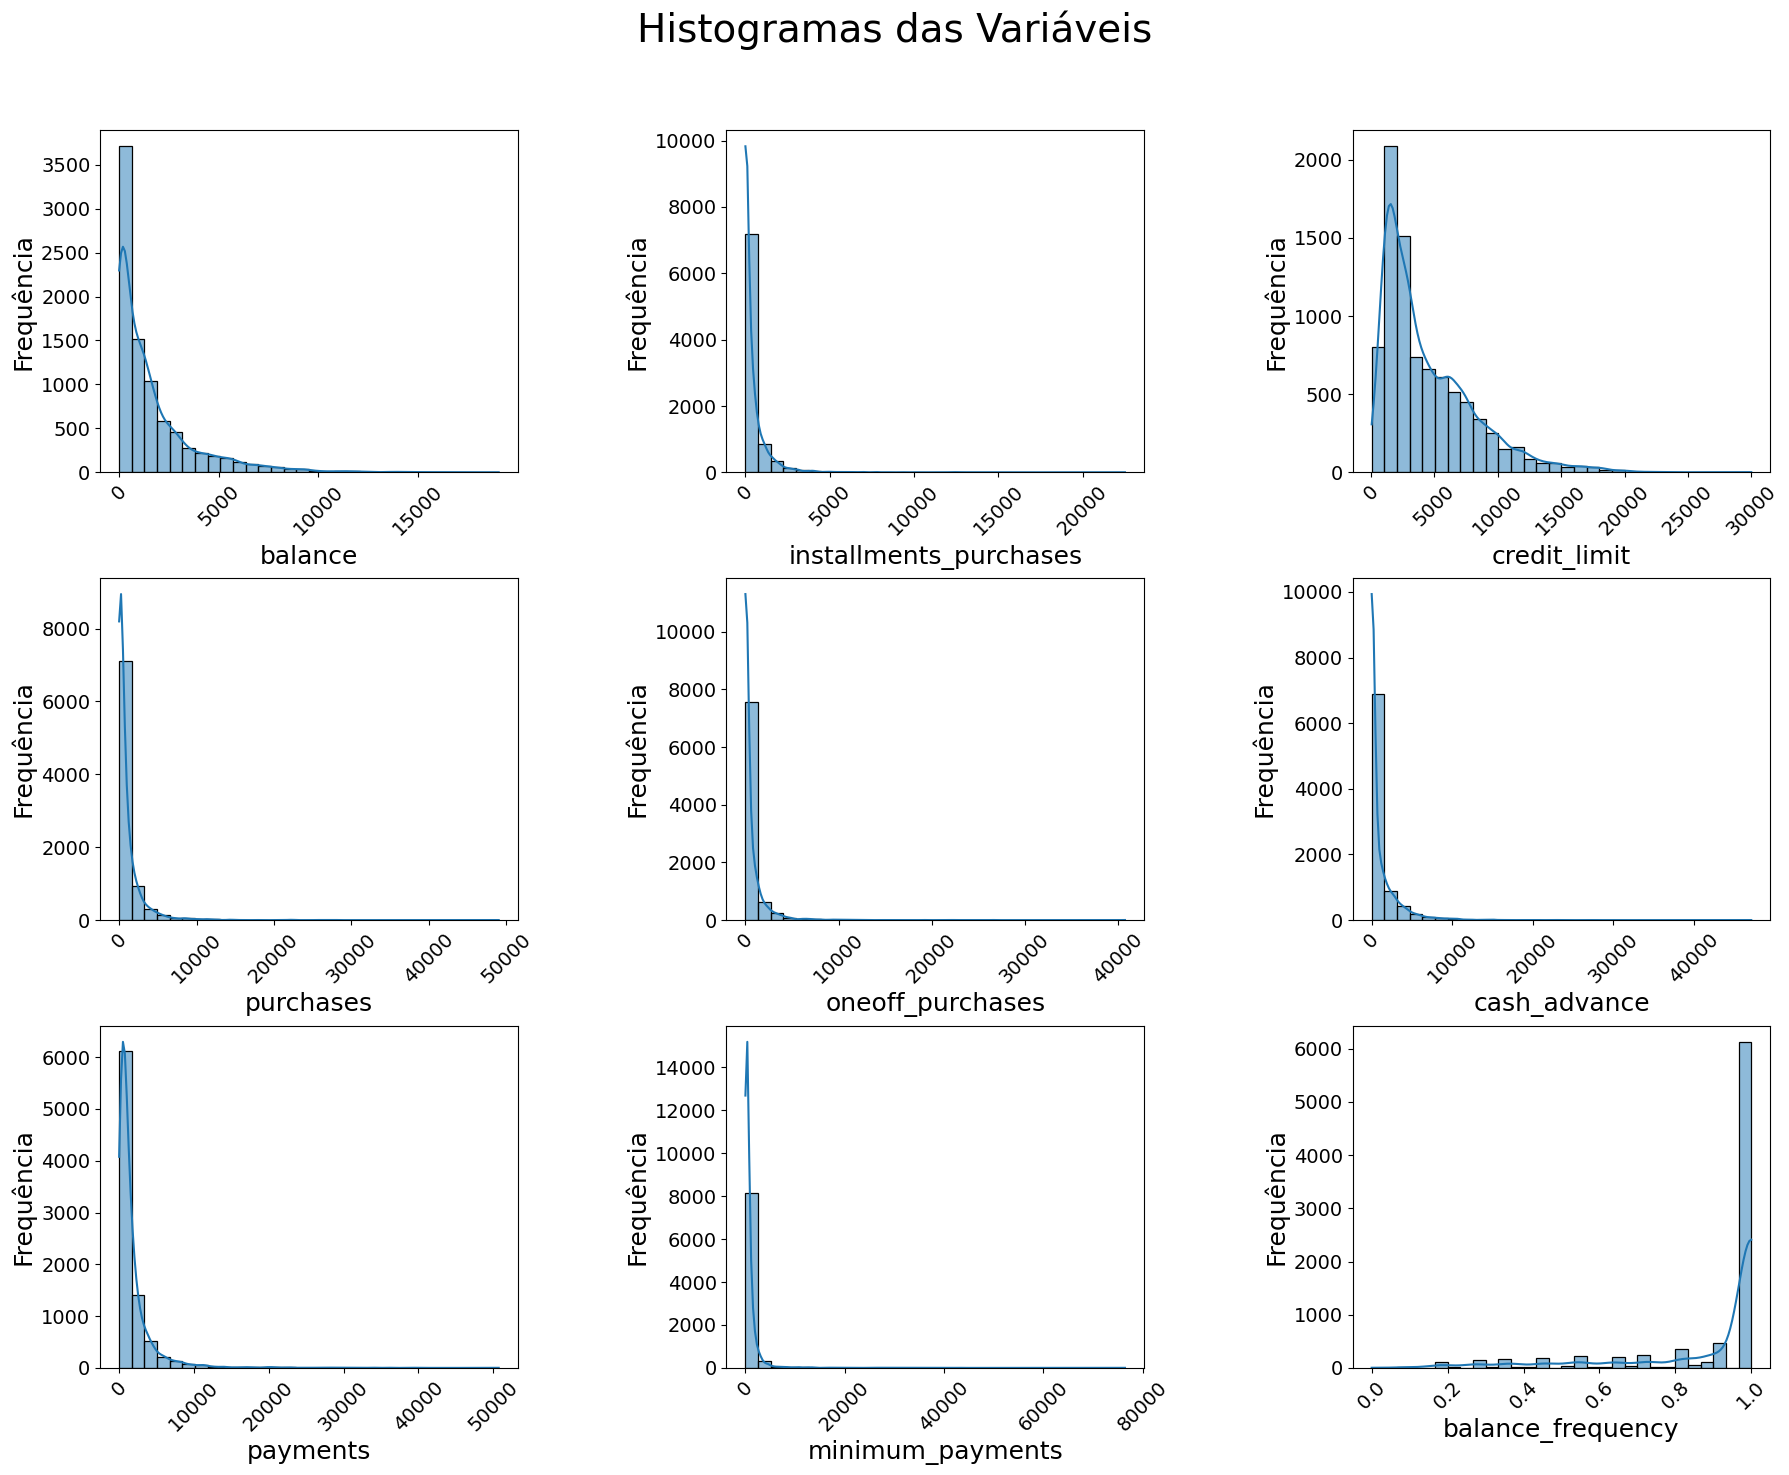

In [88]:
# Lista de variáveis para plotar
variaveis = [
    'balance', 'installments_purchases', 'credit_limit', 'purchases', 'oneoff_purchases', 
    'cash_advance', 'payments', 'minimum_payments', 'balance_frequency'
]

# Definir quantos gráficos por figura
graficos_por_figura = 9  # Número total de gráficos por figura
graficos_por_linha = 3   # Número de gráficos por linha
num_variaveis = len(variaveis)
num_figuras = math.ceil(num_variaveis / graficos_por_figura)

# Criar múltiplas figuras
for i in range(num_figuras):
    inicio = i * graficos_por_figura
    fim = min((i + 1) * graficos_por_figura, num_variaveis)
    variaveis_subset = variaveis[inicio:fim]

    num_linhas = math.ceil(len(variaveis_subset) / graficos_por_linha)
    fig, axes = plt.subplots(num_linhas, graficos_por_linha, figsize=(18, num_linhas * 5))
    
    # Garantir que axes seja uma matriz 1D para facilitar iteração
    axes = axes.flatten() if num_linhas > 1 else [axes]

    for j, var in enumerate(variaveis_subset):
        sns.histplot(df_credit_card[var], bins=30, kde=True, ax=axes[j])
        axes[j].set_xlabel(var, fontsize=18)
        axes[j].set_ylabel("Frequência", fontsize=18)
        axes[j].tick_params(axis='x', rotation=45)
        axes[j].tick_params(axis='both', which='major', labelsize=14)

    # Remover eixos vazios caso o número de variáveis não complete todos os espaços
    for k in range(j + 1, len(axes)):
        fig.delaxes(axes[k])

    plt.suptitle('Histogramas das Variáveis', fontsize=28)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, top=0.9)
    plt.show()

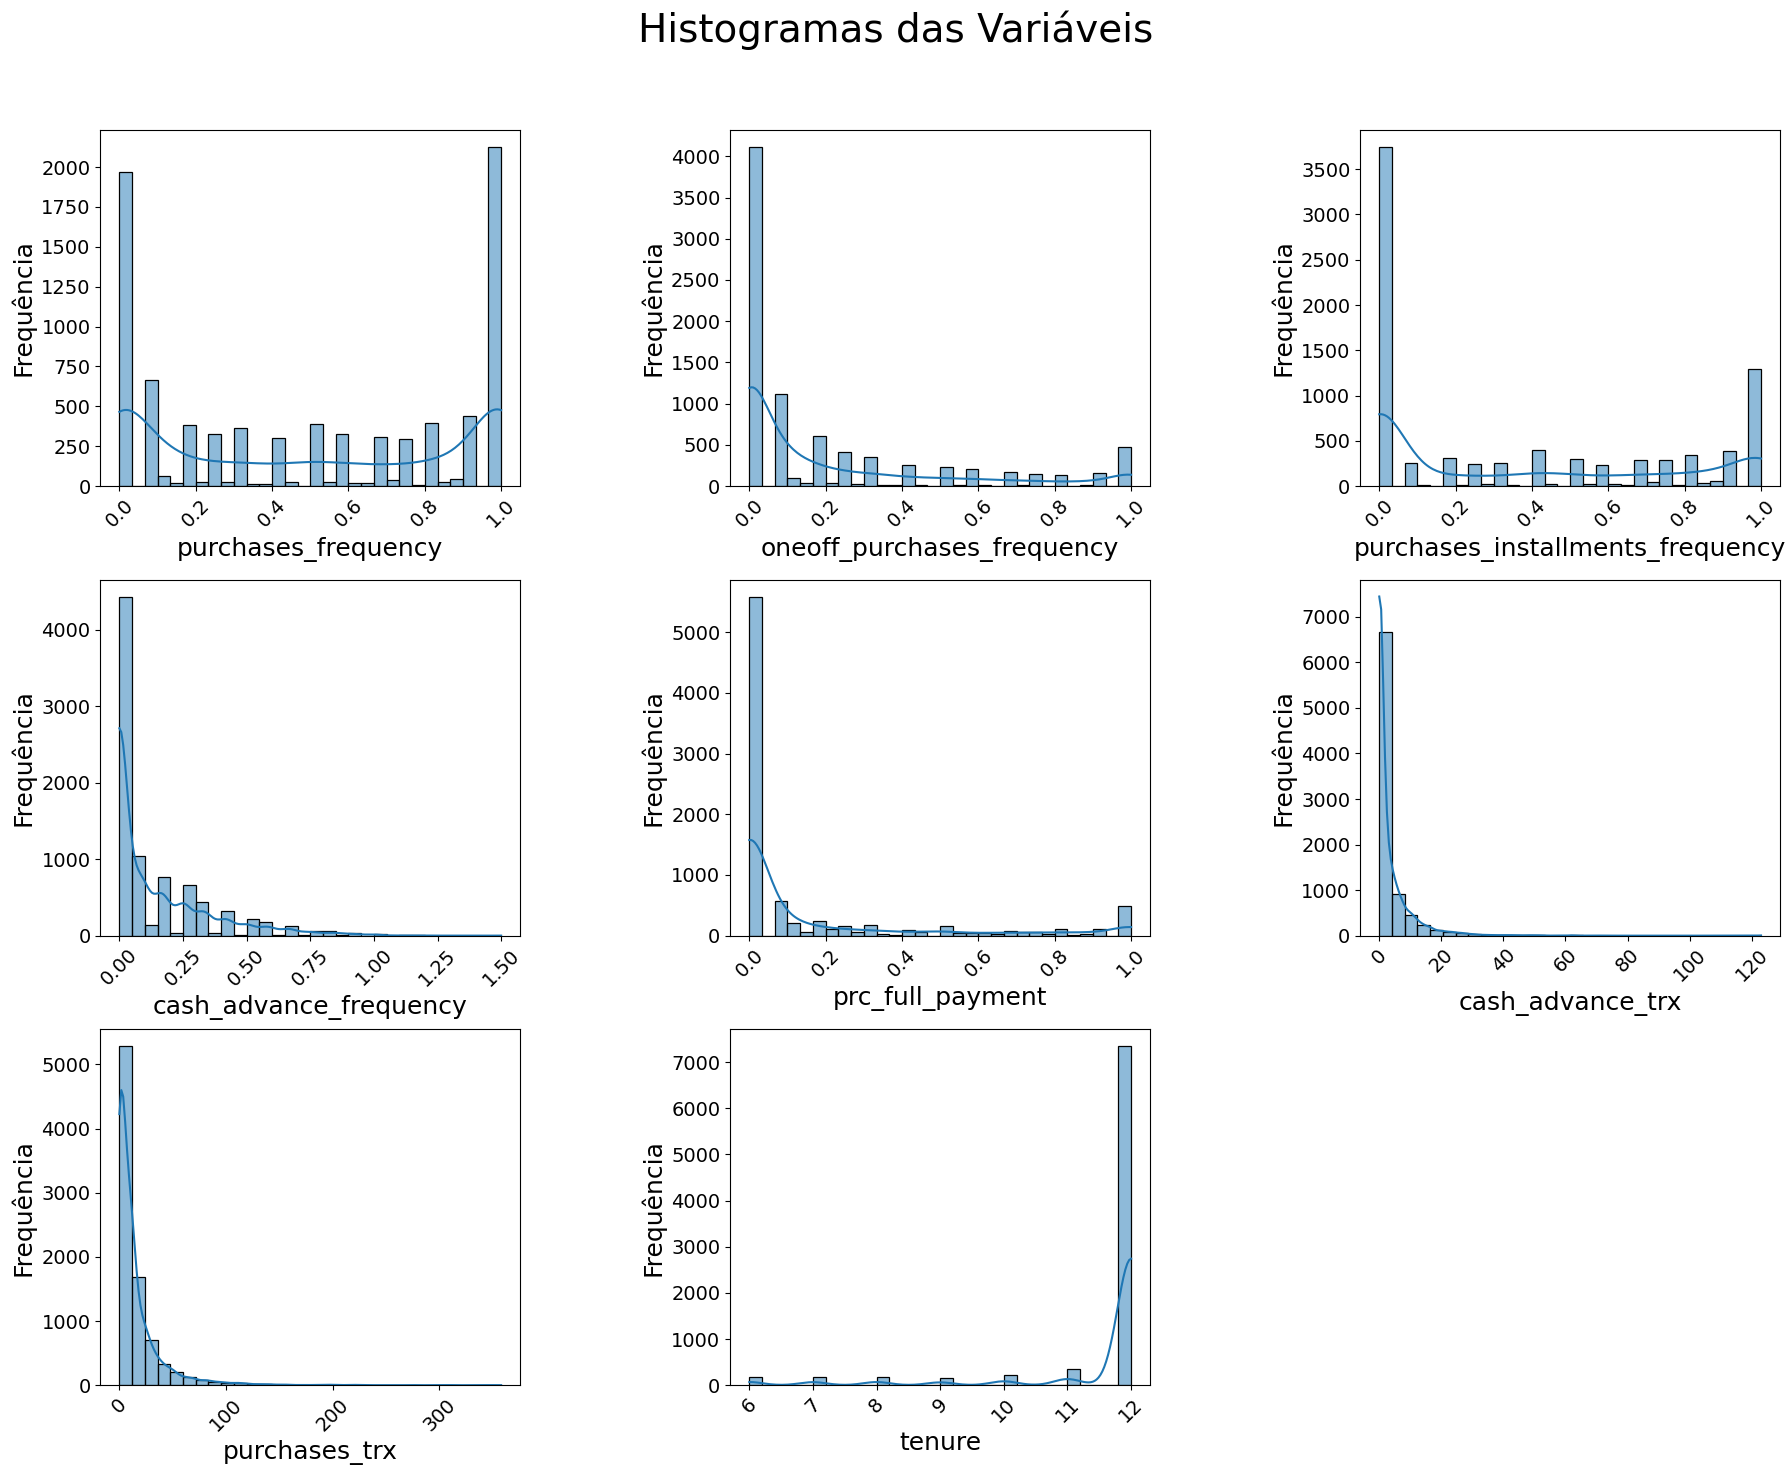

In [89]:
variaveis = [ 'purchases_frequency', 
    'oneoff_purchases_frequency', 'purchases_installments_frequency', 'cash_advance_frequency', 
    'prc_full_payment', 'cash_advance_trx', 'purchases_trx', 'tenure']

# Definir quantos gráficos por figura
graficos_por_figura = 9  # Número total de gráficos por figura
graficos_por_linha = 3   # Número de gráficos por linha
num_variaveis = len(variaveis)
num_figuras = math.ceil(num_variaveis / graficos_por_figura)

# Criar múltiplas figuras
for i in range(num_figuras):
    inicio = i * graficos_por_figura
    fim = min((i + 1) * graficos_por_figura, num_variaveis)
    variaveis_subset = variaveis[inicio:fim]

    num_linhas = math.ceil(len(variaveis_subset) / graficos_por_linha)
    fig, axes = plt.subplots(num_linhas, graficos_por_linha, figsize=(18, num_linhas * 5))
    
    # Garantir que axes seja uma matriz 1D para facilitar iteração
    axes = axes.flatten() if num_linhas > 1 else [axes]

    for j, var in enumerate(variaveis_subset):
        sns.histplot(df_credit_card[var], bins=30, kde=True, ax=axes[j])
        axes[j].set_xlabel(var, fontsize=18)
        axes[j].set_ylabel("Frequência", fontsize=18)
        axes[j].tick_params(axis='x', rotation=45)
        axes[j].tick_params(axis='both', which='major', labelsize=14)

    # Remover eixos vazios caso o número de variáveis não complete todos os espaços
    for k in range(j + 1, len(axes)):
        fig.delaxes(axes[k])

    plt.suptitle('Histogramas das Variáveis', fontsize=28)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, top=0.9)
    plt.show()

## 3.3 Correlações

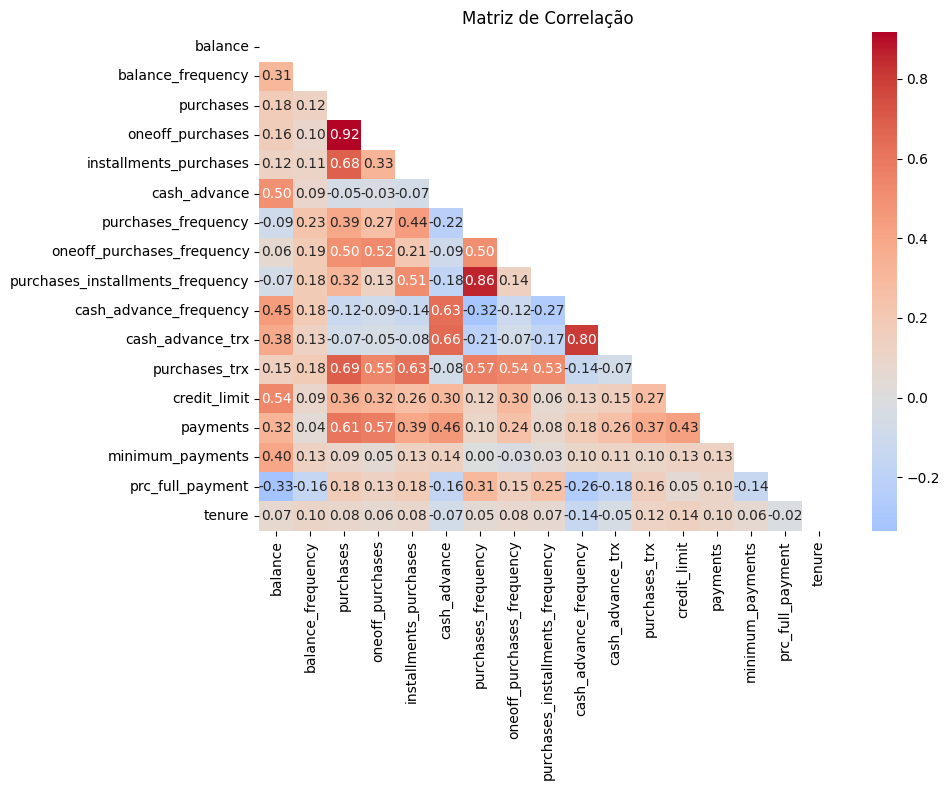

In [90]:
# Selecionar variáveis numéricas do Dataset:
colunas_numericas = df_credit_card.columns.tolist()[1:]
corr = df_credit_card[colunas_numericas].corr()

# Gerar uma máscara para a metade superior da matriz
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar a figura matplotlib
plt.figure(figsize=(10, 8))

# Desenhar o heatmap com a máscara e ajustar a paleta de cores
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0, fmt=".2f")

plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

**OBS: Os dados possuem algumas correlação importantes**

Vamos considerar:

* purchases: Correlacionado diretamente com oneoff_purchases.

* purchases_frequency: Correlacionado diretamente com purchases_installments_frequency.

* cash_advance_frequency: Correlacionado diretamente com cash_advance_trx.

# **4. Transformação de Escala e Normalização**

Como verificado na análise exploratória, o conjunto de dados possui muitos outliers. Devido à variação na grandeza, uma única variável pode apresentar valores distantes entre si (na casa dos milhares). Além disso, em sua maioria, a distribuição das variáveis numéricas é assimétrica, com uma cauda longa à direita.

Por essa composição, inicalmente vamos fazer uma **transformação da escala dos dados**. A estratégia utilizada será aplicar a transformação **[Yeo-Johnson](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)**, deixando todos os valores na mesma base. A escolha da Yeo-Johnson (uma generalização da Box-Cox) se dá por ela ser útil para dados com distribuição assimétrica, com outliers muito extremos e quando há a presença de valores negativos ou 0.

In [91]:
# Presença de zeros no Dataset:
df_credit_card[df_credit_card['balance']==0]

cust_id  balance  balance_frequency  purchases  oneoff_purchases  \
1574  C11627      0.0              0.000    2600.00           2600.00   
3787  C13895      0.0              0.091       0.01              0.01   
4937  C15076      0.0              0.000     265.76              0.00   
7052  C17244      0.0              0.000     278.00              0.00   
7440  C17643      0.0              0.000     300.00              0.00   
7673  C17879      0.0              0.000      30.98              0.00   
7834  C18047      0.0              0.000    1027.92              0.00   

      installments_purchases  cash_advance  purchases_frequency  \
1574                    0.00           0.0                0.083   
3787                    0.00           0.0                0.083   
4937                  265.76           0.0                0.917   
7052                  278.00           0.0                0.667   
7440                  300.00           0.0                0.083   
7673                   30.98           0.0                0.167   
7834                 1027.92           0.0                1.000   

      oneoff_purchases_frequency  purchases_installments_frequency  \
1574                       0.083                             0.000   
3787                       0.083                             0.000   
4937                       0.000                             0.917   
7052                       0.000                             0.667   
7440                       0.000                             0.083   
7673                       0.000                             0.167   
7834                       0.000                             1.000   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
1574                     0.0                 0              1        6000.0   
3787                     0.0                 0              1        4000.0   
4937                     0.0                 0             11        1500.0   
7052                     0.0                 0              8        1000.0   
7440                     0.0                 0              1        4000.0   
7673                     0.0                 0              2        4000.0   
7834                     0.0                 0             12        2500.0   

      payments  minimum_payments  prc_full_payment  tenure  
1574  2437.260            49.284             0.000      12  
3787     0.056             0.056             0.000      12  
4937   288.141            14.094             0.000      12  
7052   429.557            21.402             0.143      12  
7440  5228.819            81.403             0.000      12  
7673    63.582            14.458             0.091      12  
7834  1028.353            13.395             0.000      12

Na sequência, iremos aplicar a **normalização** do tipo **[RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)** em todas as variáveis numéricas, mesmo algumas variáveis estando na escala 0 a 1. Diferente da MinMaxScaler essa normalização é mais resistente a uma maior quantidade de outliers. A StandardScaler também não seria recomedável, pois ela é mais eficaz quando o conjunto de dados segue uma distribuição normal - o que não é o nosso caso -, além de também ser sensível a outliers.

Vale destacar que embora a variável 'balance_frequency', 'purchases_frequency' e 'tenure' não possuam a mesma distribuição das demais, ela concentra um alto número de outliers. Sendo assim, também vamos utilizar a combinação Yeo-Johnson + RobustScaler nela.

In [92]:
# Filtrar colunas numéricas a serem reescalads e normalizadas:
df_credit_card_numericas = df_credit_card.copy()
df_credit_card_numericas.drop('cust_id', axis=1, inplace=True)

## **4.1 Yeo-Johnson + RobustScaler**

In [93]:
# Aplicar a Transformação Yeo-Johnson (Aceita valores negativos e zero)
power_transformer = PowerTransformer(method='yeo-johnson')
df_transformed = power_transformer.fit_transform(df_credit_card_numericas)

In [94]:
# Aplicar RobustScaler (para lidar com outliers)
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df_transformed)

# Converter para DataFrame novamente
df_final_credit_card = pd.DataFrame(df_scaled, columns=df_credit_card_numericas.columns)

display(df_final_credit_card)

balance  balance_frequency  purchases  oneoff_purchases  \
0    -0.954461          -1.558434  -0.402607         -0.639137   
1     0.581502          -1.000000  -1.235050         -0.639137   
2     0.453901           0.000000   0.254251          0.394011   
3    -0.046468           0.000000  -0.796792         -0.153752   
4     0.298574           0.000000   0.468034         -0.639137   
...        ...                ...        ...               ...   
8631 -1.298685          -2.124201  -0.746283         -0.113846   
8632 -1.031092           0.000000  -0.082191         -0.639137   
8633 -1.070359          -1.487851  -0.290846         -0.639137   
8634 -1.171503          -1.487851  -1.235050         -0.639137   
8635 -0.338940          -1.977638   0.387835          0.438327   

      installments_purchases  cash_advance  purchases_frequency  \
0                   0.001056      0.000000            -0.424585   
1                  -0.729233      1.172119            -0.665961   
2                  -0.729233      0.000000             0.540298   
3                  -0.729233      0.000000            -0.543148   
4                   0.442760      0.000000             0.191280   
...                      ...           ...                  ...   
8631               -0.729233      0.000000            -0.424585   
8632                0.185439      0.000000             0.540298   
8633                0.069074      0.000000             0.370120   
8634               -0.729233      0.584880            -0.665961   
8635               -0.729233      0.747437             0.191280   

      oneoff_purchases_frequency  purchases_installments_frequency  \
0                      -0.406559                         -0.160039   
1                      -0.406559                         -0.347955   
2                       0.940380                         -0.347955   
3                       0.000000                         -0.347955   
4                      -0.406559                          0.519629   
...                          ...                               ...   
8631                    0.274847                         -0.347955   
8632                   -0.406559                          0.707902   
8633                   -0.406559                          0.589937   
8634                   -0.406559                         -0.347955   
8635                    0.851981                         -0.347955   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                   0.000000          0.000000      -0.436061     -0.756065   
1                   1.000000          1.000000      -0.926457      0.616667   
2                   0.000000          0.000000       0.215237      0.668214   
3                   0.000000          0.000000      -0.616809     -0.633893   
4                   0.000000          0.000000       0.052253     -0.357522   
...                      ...               ...            ...           ...   
8631                0.000000          0.000000      -0.616809     -1.208855   
8632                0.000000          0.000000      -0.059269     -0.756065   
8633                0.000000          0.000000      -0.127727     -0.756065   
8634                0.809985          0.787873      -0.926457     -1.208855   
8635                1.123078          0.787873       0.486462     -0.633893   

      payments  minimum_payments  prc_full_payment    tenure  
0    -0.958474         -0.522052          0.000000  0.000000  
1     0.997932          0.762497          1.150002  0.000000  
2    -0.236933          0.436318          0.000000  0.000000  
3    -0.180930         -0.156079          0.000000  0.000000  
4     0.290323          1.238980          0.000000  0.000000  
...        ...               ...               ...       ...  
8631 -1.733722         -1.306774          0.000000 -2.968753  
8632 -0.653406         -1.226463          1.467138 -2.968753  
8633 -1.531144         -0.872327          1.208904 -

## **4.2 Distribuição de variáveis e outliers após aplicar Yeo-Johnson + RobustScaler**

In [95]:
df_final_credit_card.describe()

balance  balance_frequency    purchases  oneoff_purchases  \
count  8636.000000        8636.000000  8636.000000       8636.000000   
mean     -0.096486          -0.507090    -0.119303         -0.133735   
std       0.652918           0.827715     0.739452          0.501208   
min      -1.554251          -2.172062    -1.235050         -0.639137   
25%      -0.629508          -1.000000    -0.593378         -0.639137   
50%       0.000000           0.000000     0.000000          0.000000   
75%       0.370492           0.000000     0.406622          0.360863   
max       1.697411           0.000000     2.516991          0.855576   

       installments_purchases  cash_advance  purchases_frequency  \
count             8636.000000   8636.000000          8636.000000   
mean                -0.181313      0.474801            -0.044994   
std                  0.501491      0.499159             0.482985   
min                 -0.729233      0.000000            -0.665961   
25%                 -0.729233      0.000000            -0.543148   
50%                  0.000000      0.000000             0.000000   
75%                  0.270767      1.000000             0.456852   
max                  0.936163      1.342040             0.540298   

       oneoff_purchases_frequency  purchases_installments_frequency  \
count                 8636.000000                       8636.000000   
mean                     0.058273                          0.141518   
std                      0.511430                          0.483696   
min                     -0.406559                         -0.347955   
25%                     -0.406559                         -0.347955   
50%                      0.000000                          0.000000   
75%                      0.593441                          0.652045   
max                      0.940380                          0.804727   

       cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
count             8636.000000       8636.000000    8636.000000   8636.000000   
mean                 0.446246          0.470654      -0.073988      0.079956   
std                  0.502341          0.516171       0.612165      0.586631   
min                  0.000000          0.000000      -0.926457     -2.582391   
25%                  0.000000          0.000000      -0.616809     -0.438473   
50%                  0.000000          0.000000       0.000000      0.000000   
75%                  1.000000          1.000000       0.383191      0.561527   
max                  1.403016          1.466842       1.675559      1.748319   

          payments  minimum_payments  prc_full_payment       tenure  
count  8636.000000      8.636000e+03       8636.000000  8636.000000  
mean      0.015289      8.955387e-02          0.425965    -0.417156  
std       0.754395      7.502333e-01          0.614443     1.000058  
min      -4.209940     -4.212186e+00          0.000000    -2.968753  
25%      -0.492302     -3.956191e-01          0.000000     0.000000  
50%       0.000000      5.204170e-18          0.000000     0.000000  
75%       0.507698      6.043809e-01          1.000000     0.000000  
max       2.691101      3.079633e+00          1.563755     0.000000

In [96]:
# Cópia do Dataset para visualizações e clusterizações
df = df_final_credit_card.copy()

In [97]:
df.head()

balance  balance_frequency  purchases  oneoff_purchases  \
0 -0.954461          -1.558434  -0.402607         -0.639137   
1  0.581502          -1.000000  -1.235050         -0.639137   
2  0.453901           0.000000   0.254251          0.394011   
3 -0.046468           0.000000  -0.796792         -0.153752   
4  0.298574           0.000000   0.468034         -0.639137   

   installments_purchases  cash_advance  purchases_frequency  \
0                0.001056      0.000000            -0.424585   
1               -0.729233      1.172119            -0.665961   
2               -0.729233      0.000000             0.540298   
3               -0.729233      0.000000            -0.543148   
4                0.442760      0.000000             0.191280   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                   -0.406559                         -0.160039   
1                   -0.406559                         -0.347955   
2                    0.940380                         -0.347955   
3                    0.000000                         -0.347955   
4                   -0.406559                          0.519629   

   cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                     0.0               0.0      -0.436061     -0.756065   
1                     1.0               1.0      -0.926457      0.616667   
2                     0.0               0.0       0.215237      0.668214   
3                     0.0               0.0      -0.616809     -0.633893   
4                     0.0               0.0       0.052253     -0.357522   

   payments  minimum_payments  prc_full_payment  tenure  
0 -0.958474         -0.522052          0.000000     0.0  
1  0.997932          0.762497          1.150002     0.0  
2 -0.236933          0.436318          0.000000     0.0  
3 -0.180930         -0.156079          0.000000     0.0  
4  0.290323          1.238980          0.000000     0.0

## 4.3 Análise de Outliers

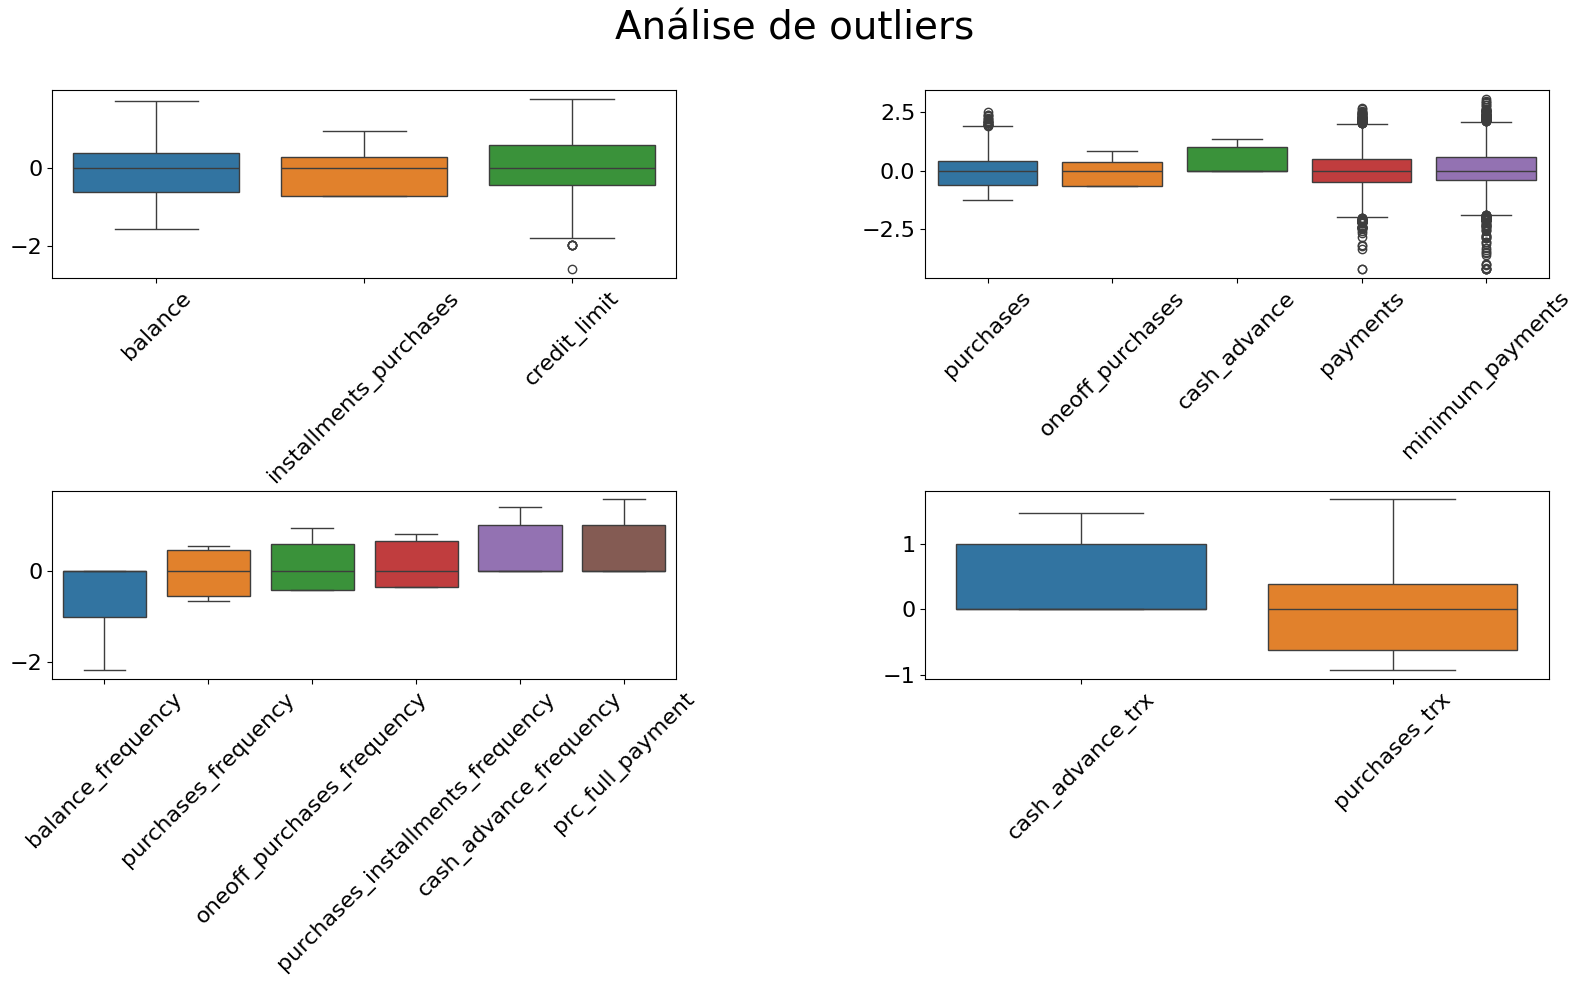

In [98]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Primeiro gráfico
sns.boxplot(data=df[['balance', 'installments_purchases', 'credit_limit']], orient="v", ax=axes[0, 0])
axes[0, 0].tick_params(axis='x', labelsize=16)
axes[0, 0].tick_params(axis='y', labelsize=16)
axes[0, 0].tick_params(axis='x', rotation=45)

# Segundo gráfico
sns.boxplot(data=df[['purchases', 'oneoff_purchases', 'cash_advance', 'payments', 
                            'minimum_payments']], orient="v", ax=axes[0, 1])
axes[0, 1].tick_params(axis='x', labelsize=16)
axes[0, 1].tick_params(axis='y', labelsize=16)
axes[0, 1].tick_params(axis='x', rotation=45)

# Terceiro gráfico
sns.boxplot(data=df[['balance_frequency', 'purchases_frequency', 'oneoff_purchases_frequency',
                           'purchases_installments_frequency', 'cash_advance_frequency',
                            'prc_full_payment']], orient="v", ax=axes[1, 0])
axes[1, 0].tick_params(axis='x', labelsize=16)
axes[1, 0].tick_params(axis='y', labelsize=16)
axes[1, 0].tick_params(axis='x', rotation=45)

# Quarto gráfico
sns.boxplot(data=df[['cash_advance_trx', 'purchases_trx']], orient="v", ax=axes[1, 1])
axes[1, 1].tick_params(axis='x', labelsize=16)
axes[1, 1].tick_params(axis='y', labelsize=16)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Análise de outliers', fontsize=28)
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, top=0.9)

plt.show()

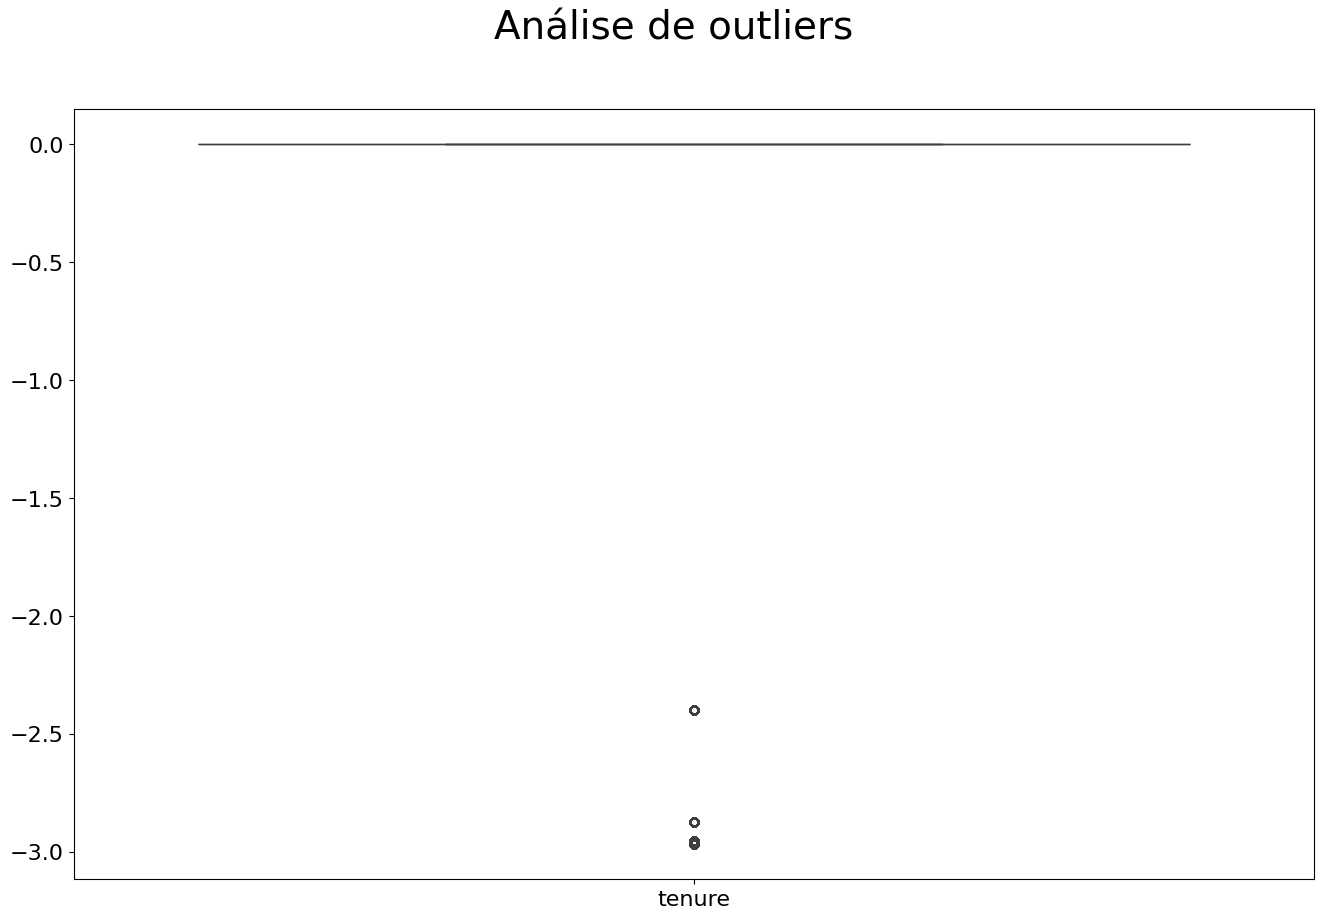

In [99]:
fig, axes = plt.subplots(1, 1, figsize=(16, 10))

sns.boxplot(data=df[['tenure']], orient="v")
axes.tick_params(axis='x', labelsize=16)
axes.tick_params(axis='y', labelsize=16)
plt.suptitle('Análise de outliers', fontsize=28)

plt.show()

## 4.4 Análise de Distribuições

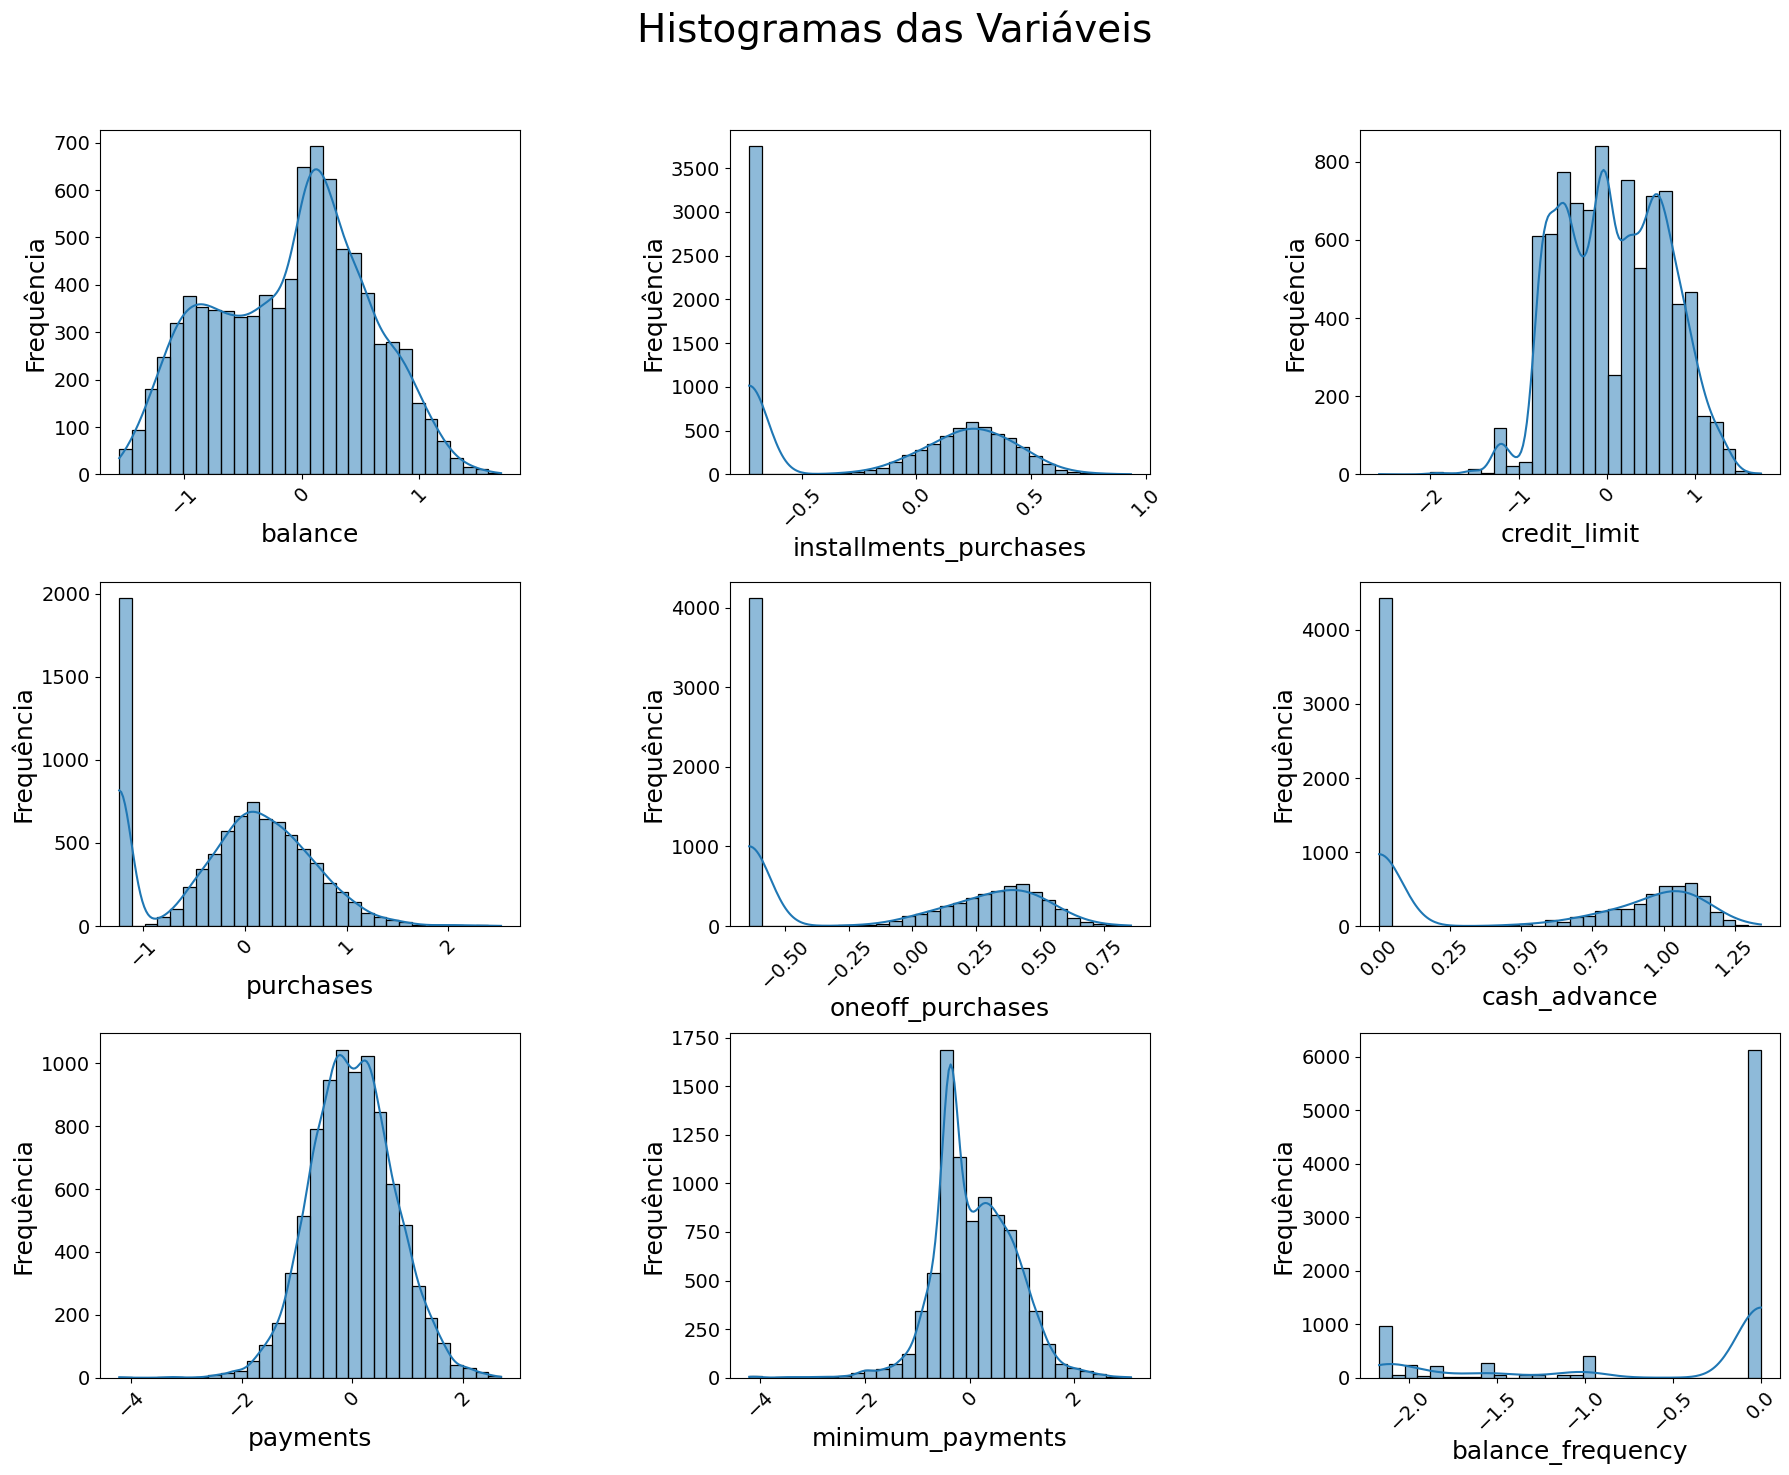

In [100]:
# Lista de variáveis para plotar
variaveis = [
    'balance', 'installments_purchases', 'credit_limit', 'purchases', 'oneoff_purchases', 
    'cash_advance', 'payments', 'minimum_payments', 'balance_frequency'
]

# Definir quantos gráficos por figura
graficos_por_figura = 9  # Número total de gráficos por figura
graficos_por_linha = 3   # Número de gráficos por linha
num_variaveis = len(variaveis)
num_figuras = math.ceil(num_variaveis / graficos_por_figura)

# Criar múltiplas figuras
for i in range(num_figuras):
    inicio = i * graficos_por_figura
    fim = min((i + 1) * graficos_por_figura, num_variaveis)
    variaveis_subset = variaveis[inicio:fim]

    num_linhas = math.ceil(len(variaveis_subset) / graficos_por_linha)
    fig, axes = plt.subplots(num_linhas, graficos_por_linha, figsize=(18, num_linhas * 5))
    
    # Garantir que axes seja uma matriz 1D para facilitar iteração
    axes = axes.flatten() if num_linhas > 1 else [axes]

    for j, var in enumerate(variaveis_subset):
        sns.histplot(df[var], bins=30, kde=True, ax=axes[j])
        axes[j].set_xlabel(var, fontsize=18)
        axes[j].set_ylabel("Frequência", fontsize=18)
        axes[j].tick_params(axis='x', rotation=45)
        axes[j].tick_params(axis='both', which='major', labelsize=14)

    # Remover eixos vazios caso o número de variáveis não complete todos os espaços
    for k in range(j + 1, len(axes)):
        fig.delaxes(axes[k])

    plt.suptitle('Histogramas das Variáveis', fontsize=28)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, top=0.9)
    plt.show()

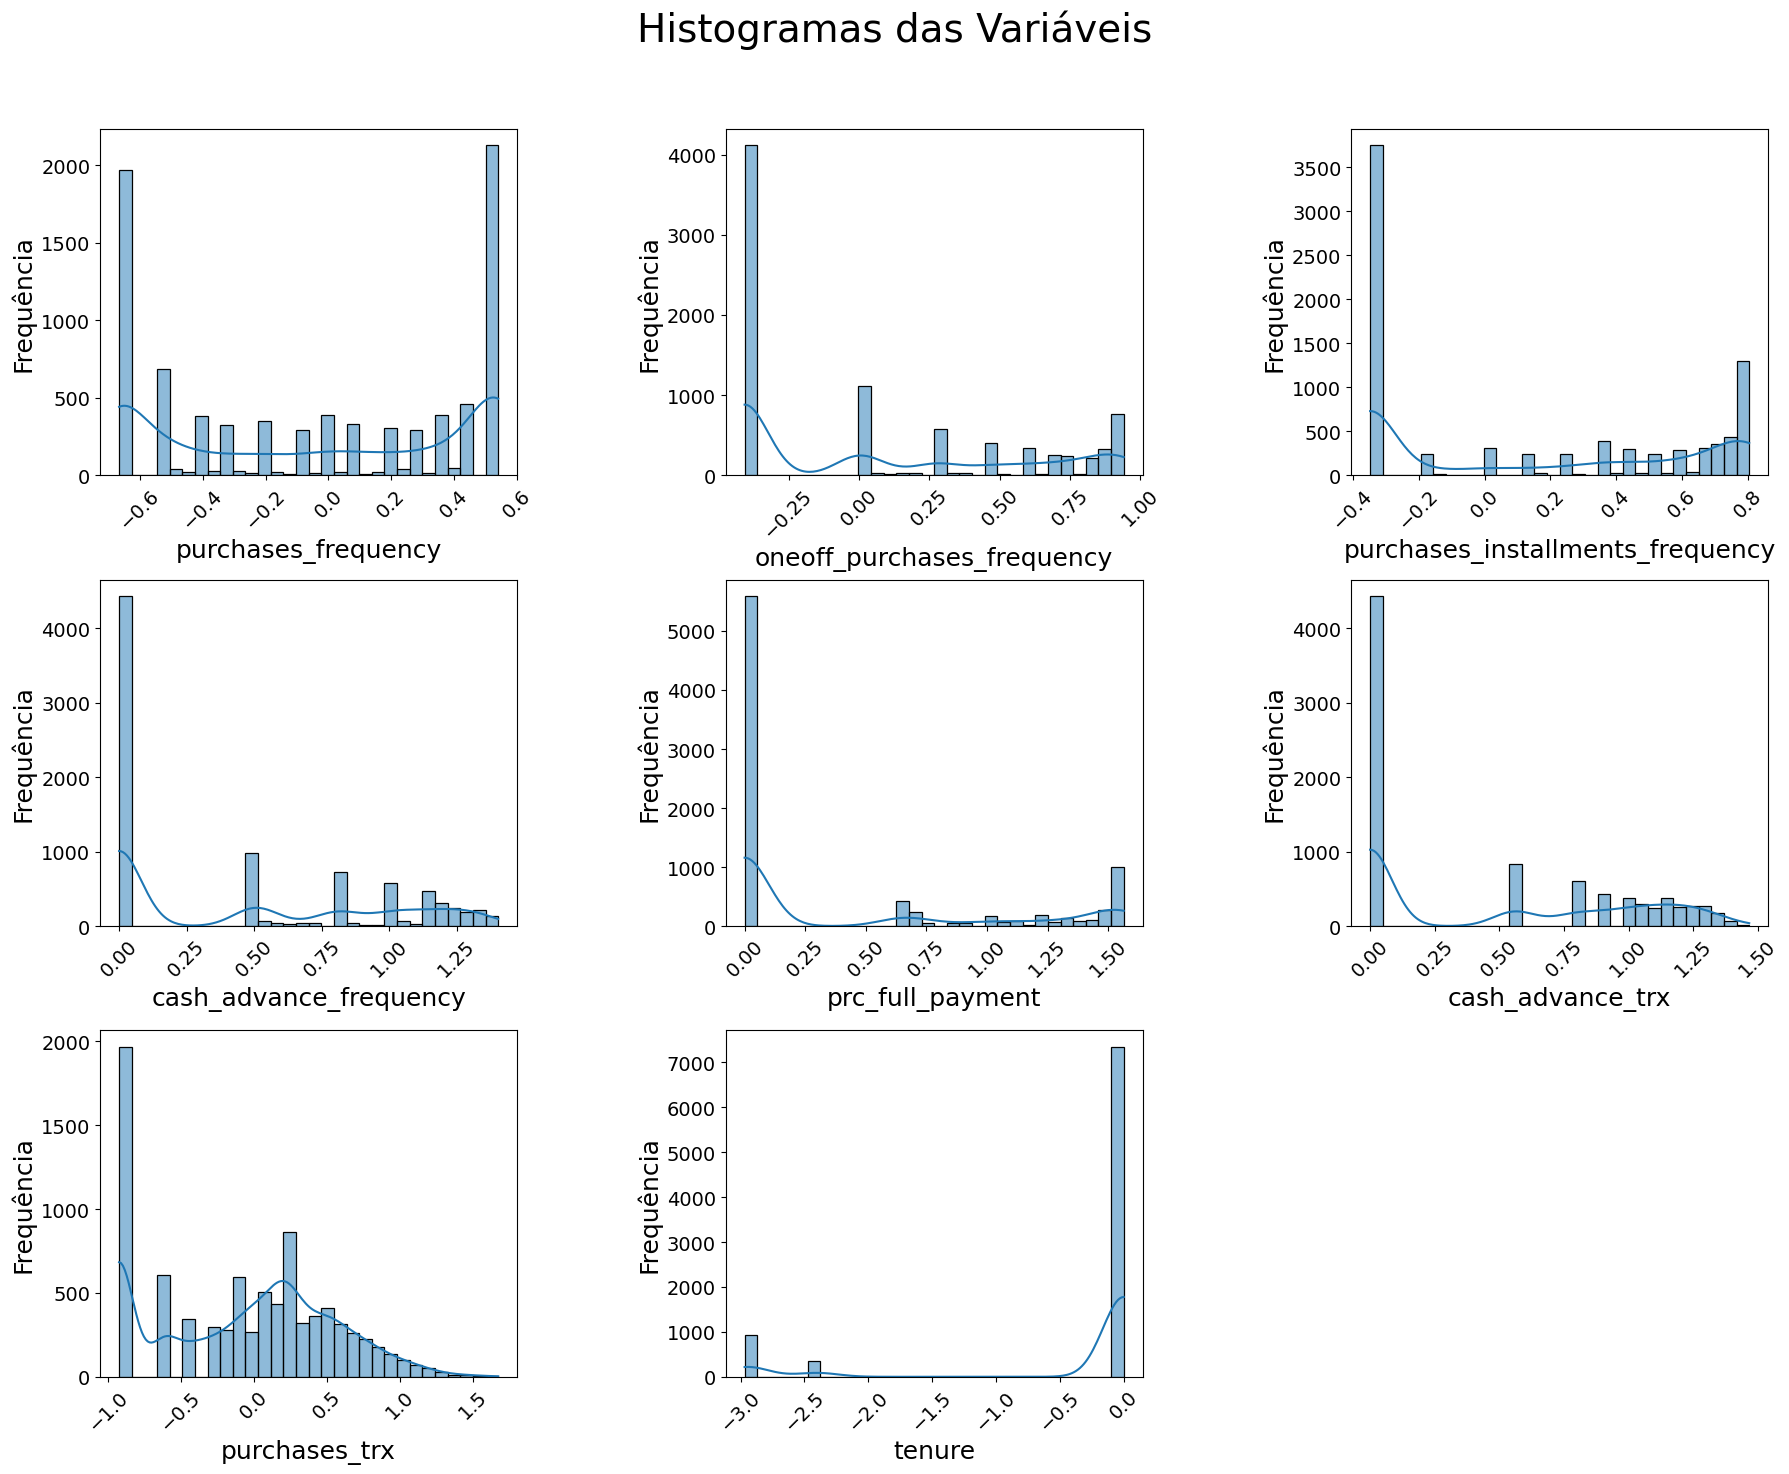

In [101]:
variaveis = [ 'purchases_frequency', 
    'oneoff_purchases_frequency', 'purchases_installments_frequency', 'cash_advance_frequency', 
    'prc_full_payment', 'cash_advance_trx', 'purchases_trx', 'tenure']

# Definir quantos gráficos por figura
graficos_por_figura = 9  # Número total de gráficos por figura
graficos_por_linha = 3   # Número de gráficos por linha
num_variaveis = len(variaveis)
num_figuras = math.ceil(num_variaveis / graficos_por_figura)

# Criar múltiplas figuras
for i in range(num_figuras):
    inicio = i * graficos_por_figura
    fim = min((i + 1) * graficos_por_figura, num_variaveis)
    variaveis_subset = variaveis[inicio:fim]

    num_linhas = math.ceil(len(variaveis_subset) / graficos_por_linha)
    fig, axes = plt.subplots(num_linhas, graficos_por_linha, figsize=(18, num_linhas * 5))
    
    # Garantir que axes seja uma matriz 1D para facilitar iteração
    axes = axes.flatten() if num_linhas > 1 else [axes]

    for j, var in enumerate(variaveis_subset):
        sns.histplot(df[var], bins=30, kde=True, ax=axes[j])
        axes[j].set_xlabel(var, fontsize=18)
        axes[j].set_ylabel("Frequência", fontsize=18)
        axes[j].tick_params(axis='x', rotation=45)
        axes[j].tick_params(axis='both', which='major', labelsize=14)

    # Remover eixos vazios caso o número de variáveis não complete todos os espaços
    for k in range(j + 1, len(axes)):
        fig.delaxes(axes[k])

    plt.suptitle('Histogramas das Variáveis', fontsize=28)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, top=0.9)
    plt.show()

Pelos histogramas e boxplots apresentados, aplicar a transformação Yeo-Johnson junto com a normalização RobustScaler foi uma ótima escolha. Essa combinação reduziu bastante o número de outliers e a assimetria das distribuições, aproximando-as de uma gaussiana (normal).

## 4.5 Correlações

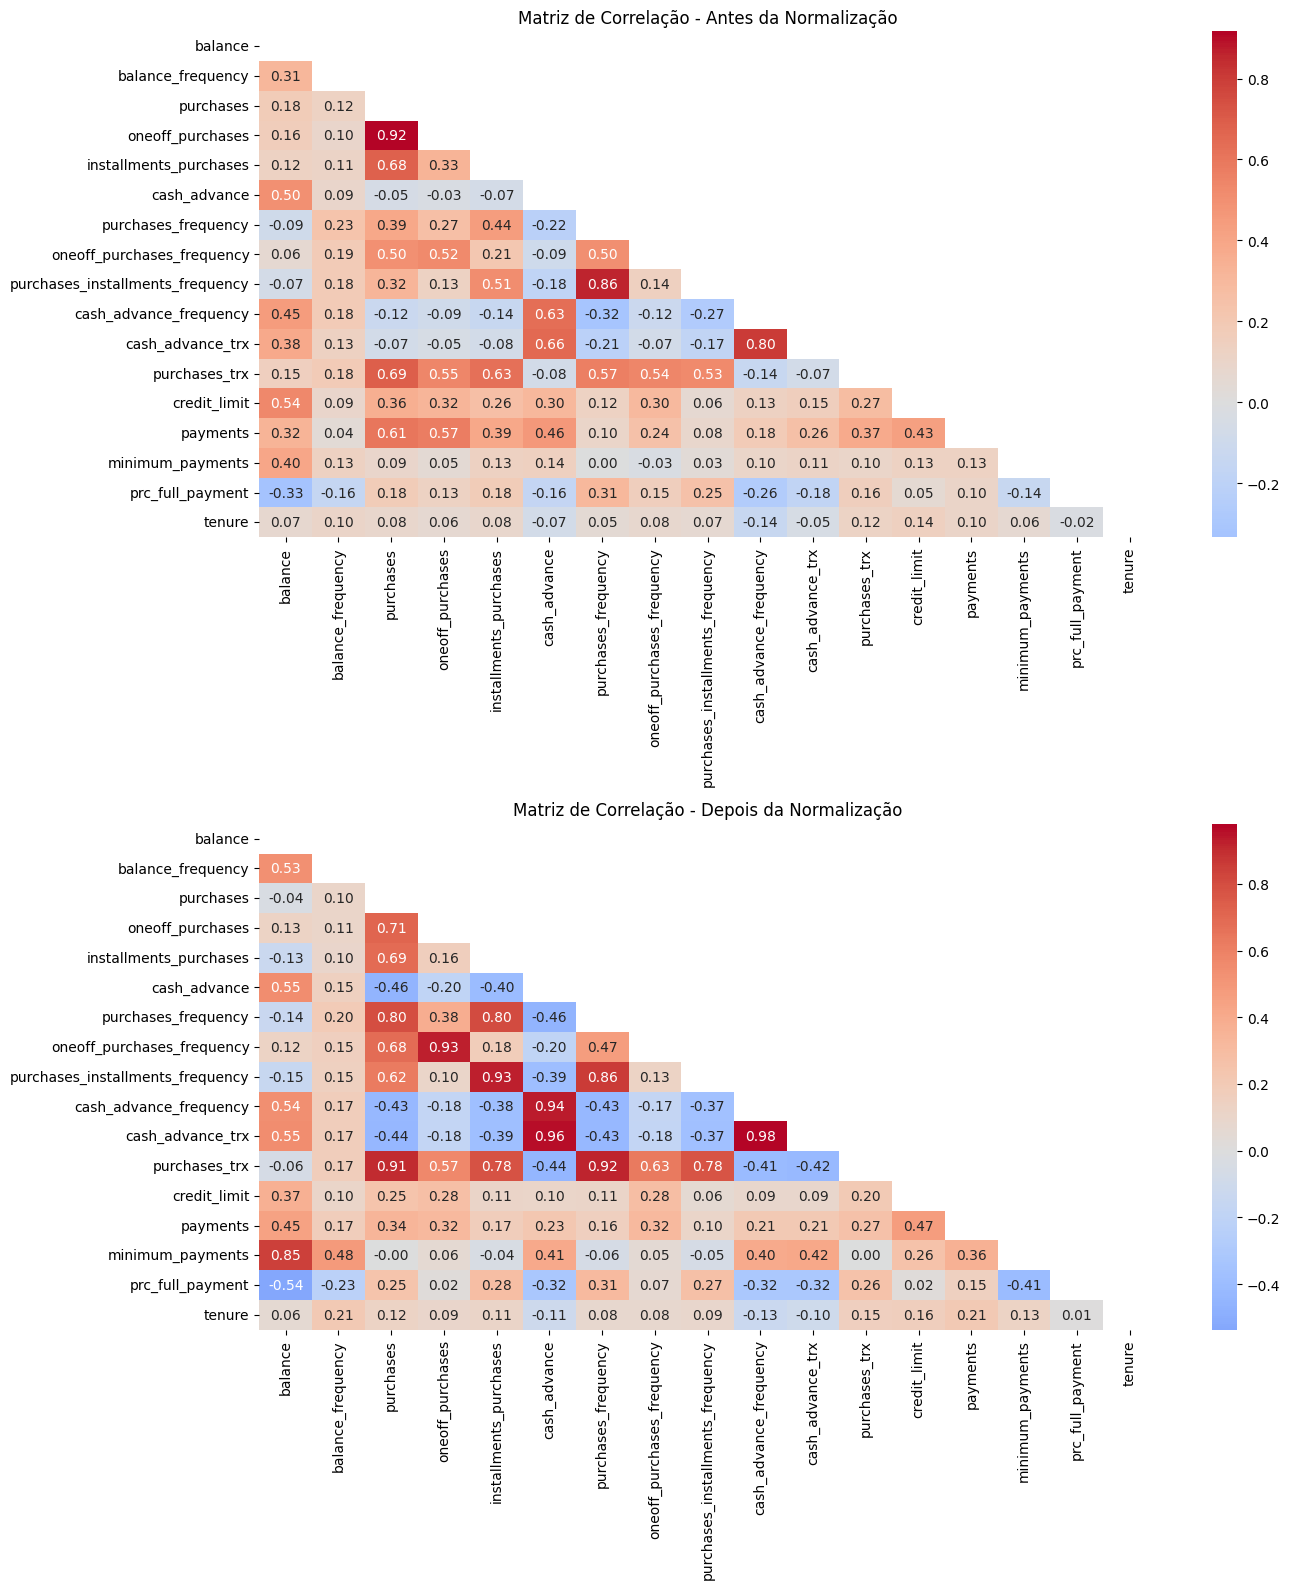

In [102]:
def plot_correlation_matrices(df1, df2, title1='Dataset 1', title2='Dataset 2'):
    colunas_numericas1 = df1.columns.tolist()[1:]
    colunas_numericas2 = df1.columns.tolist()[1:]
    
    corr1 = df1[colunas_numericas1].corr()
    corr2 = df2[colunas_numericas2].corr()
    
    # Gerar máscaras para a metade superior das matrizes
    mask1 = np.triu(np.ones_like(corr1, dtype=bool))
    mask2 = np.triu(np.ones_like(corr2, dtype=bool))
    
    # Criar figura e eixos
    fig, axes = plt.subplots(2, 1, figsize=(14, 16))
    
    # Heatmap para o primeiro dataset
    sns.heatmap(corr1, mask=mask1, annot=True, cmap='coolwarm', center=0, fmt=".2f", ax=axes[0])
    axes[0].set_title(title1)
    
    # Heatmap para o segundo dataset
    sns.heatmap(corr2, mask=mask2, annot=True, cmap='coolwarm', center=0, fmt=".2f", ax=axes[1])
    axes[1].set_title(title2)
    
    plt.tight_layout()
    plt.show()

# Chamada da função para comparar os dois datasets
plot_correlation_matrices(df_credit_card, df, 'Matriz de Correlação - Antes da Normalização',
                          'Matriz de Correlação - Depois da Normalização')

Após todo o processo de transformação e normalização dos dados, observamos nesses dois gráficos heatmap(correlação) das variáveis que as correlações posteriores aumentaram em relação às anteriores. 

# 5. Redução de Dimensionalidade

## 5.1 PCA

Nesta etapa, realizamos a redução de dimensionalidade usando PCA com o objetivo de encontrar o menor número de componentes principais possível, preservando o máximo de informação (variância) dos dados. Para isso, identificamos as direções de maior variação nos dados e descartamos aquelas que menos contribuem. Como resultado, reduzimos ruídos, eliminamos variáveis com pouca variância (que não agregam ao modelo) e diminuímos os custos computacionais.

* Pegamos os 6 primeiros componentes que possuem 87% de informações dos dados principais para usar nas etapas seguintes.

* Os 6 componentes não possuem correlação.

In [103]:
x = df.values

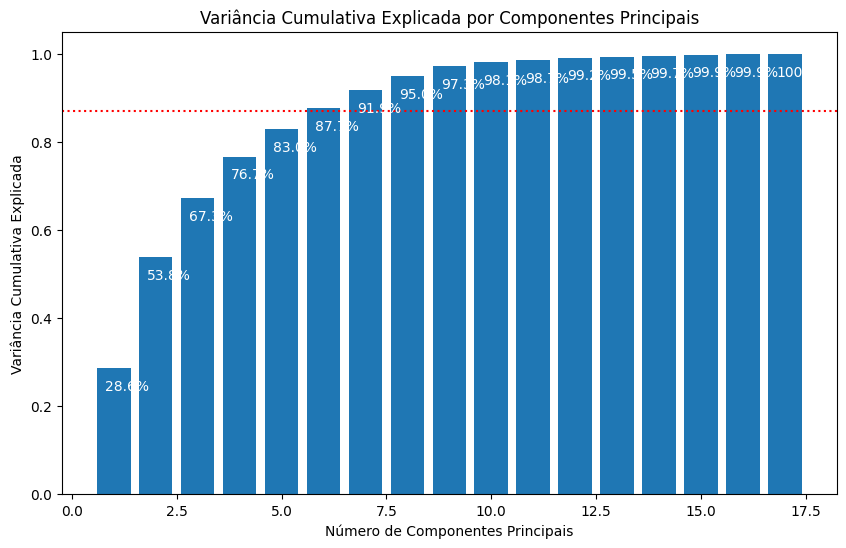

In [104]:
# Início do PCA com o número de componentes desejado ou None para manter todos os componentes
n_components = None
pca = PCA(n_components=n_components)

# Ajuste do modelo PCA aos seus dados
pca.fit(x)

# Cálculo da variância explicada cumulativa
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Gráfico da variância cumulativa
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative)
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Cumulativa Explicada')
plt.title('Variância Cumulativa Explicada por Componentes Principais')
plt.axhline(y=0.87, c='red', linestyle=':')

# Adição das porcentagens como rótulos nas barras
for bar, explained_variance in zip(bars, explained_variance_ratio_cumulative):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.2, bar.get_height() - 0.05, f'{explained_variance:.1%}', fontsize=10, color='white')

plt.show()

In [105]:
pca = PCA(n_components=0.87)
#pca = PCA(n_components=6)

principalComponents = pca.fit_transform(x)

columns = []

for i in range(principalComponents.shape[1]):
  columns.append(f'Principal component {i}')

principalDf = pd.DataFrame(data = principalComponents, columns = columns)

principalDf

Principal component 0  Principal component 1  Principal component 2  \
0                 -0.479496              -1.824755               1.050690   
1                 -1.671676               0.987890               0.539157   
2                  0.808721               0.744750               0.109852   
3                 -0.711124              -0.246081               0.899379   
4                  0.703475               0.799495               0.249067   
...                     ...                    ...                    ...   
8631              -1.468255              -3.618226              -1.466468   
8632               0.193298              -2.446209              -1.834030   
8633              -0.347825              -3.184534              -1.732088   
8634              -2.436742              -3.187199              -1.341286   
8635              -0.694108              -2.013228              -2.479119   

      Principal component 3  Principal component 4  Principal component 5  
0                  0.338382               0.324694              -0.722335  
1                 -1.468033              -0.812245               0.001043  
2                  0.332834               1.390618               0.078449  
3                  0.652112               0.709284               0.403040  
4                  0.983295              -0.452257              -0.981464  
...                     ...                    ...                    ...  
8631               0.470083               1.246926              -0.078939  
8632               1.233021              -1.119544               1.017852  
8633               0.875852              -0.564989              -0.156242  
8634               0.439678              -0.180496               0.742507  
8635               0.065825               1.436551              -0.059021  

[8636 rows x 6 columns]

In [106]:
PCA_finalDf = pd.concat([principalDf, df], axis = 1)
PCA_finalDf

Principal component 0  Principal component 1  Principal component 2  \
0                 -0.479496              -1.824755               1.050690   
1                 -1.671676               0.987890               0.539157   
2                  0.808721               0.744750               0.109852   
3                 -0.711124              -0.246081               0.899379   
4                  0.703475               0.799495               0.249067   
...                     ...                    ...                    ...   
8631              -1.468255              -3.618226              -1.466468   
8632               0.193298              -2.446209              -1.834030   
8633              -0.347825              -3.184534              -1.732088   
8634              -2.436742              -3.187199              -1.341286   
8635              -0.694108              -2.013228              -2.479119   

      Principal component 3  Principal component 4  Principal component 5  \
0                  0.338382               0.324694              -0.722335   
1                 -1.468033              -0.812245               0.001043   
2                  0.332834               1.390618               0.078449   
3                  0.652112               0.709284               0.403040   
4                  0.983295              -0.452257              -0.981464   
...                     ...                    ...                    ...   
8631               0.470083               1.246926              -0.078939   
8632               1.233021              -1.119544               1.017852   
8633               0.875852              -0.564989              -0.156242   
8634               0.439678              -0.180496               0.742507   
8635               0.065825               1.436551              -0.059021   

       balance  balance_frequency  purchases  oneoff_purchases  ...  \
0    -0.954461          -1.558434  -0.402607         -0.639137  ...   
1     0.581502          -1.000000  -1.235050         -0.639137  ...   
2     0.453901           0.000000   0.254251          0.394011  ...   
3    -0.046468           0.000000  -0.796792         -0.153752  ...   
4     0.298574           0.000000   0.468034         -0.639137  ...   
...        ...                ...        ...               ...  ...   
8631 -1.298685          -2.124201  -0.746283         -0.113846  ...   
8632 -1.031092           0.000000  -0.082191         -0.639137  ...   
8633 -1.070359          -1.487851  -0.290846         -0.639137  ...   
8634 -1.171503          -1.487851  -1.235050         -0.639137  ...   
8635 -0.338940          -1.977638   0.387835          0.438327  ...   

      oneoff_purchases_frequency  purchases_installments_frequency  \
0                      -0.406559                         -0.160039   
1                      -0.406559                         -0.347955   
2                       0.940380                         -0.347955   
3                       0.000000                         -0.347955   
4                      -0.406559                          0.519629   
...                          ...                               ...   
8631                    0.274847                         -0.347955   
8632                   -0.406559                          0.707902   
8633                   -0.406559                          0.589937   
8634                   -0.406559                         -0.347955   
8635                    0.851981                         -0.347955   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                   0.000000          0.000000      -0.436061     -0.756065   
1                   1.000000          1.000000      -0.926457      0.616667   
2                   0.000000          0.000000       0.215237      0.668214   
3                   0.000000          0.000000      -0.616809     -0.633893   
4                   0.000000          0.000000       0.052253     -

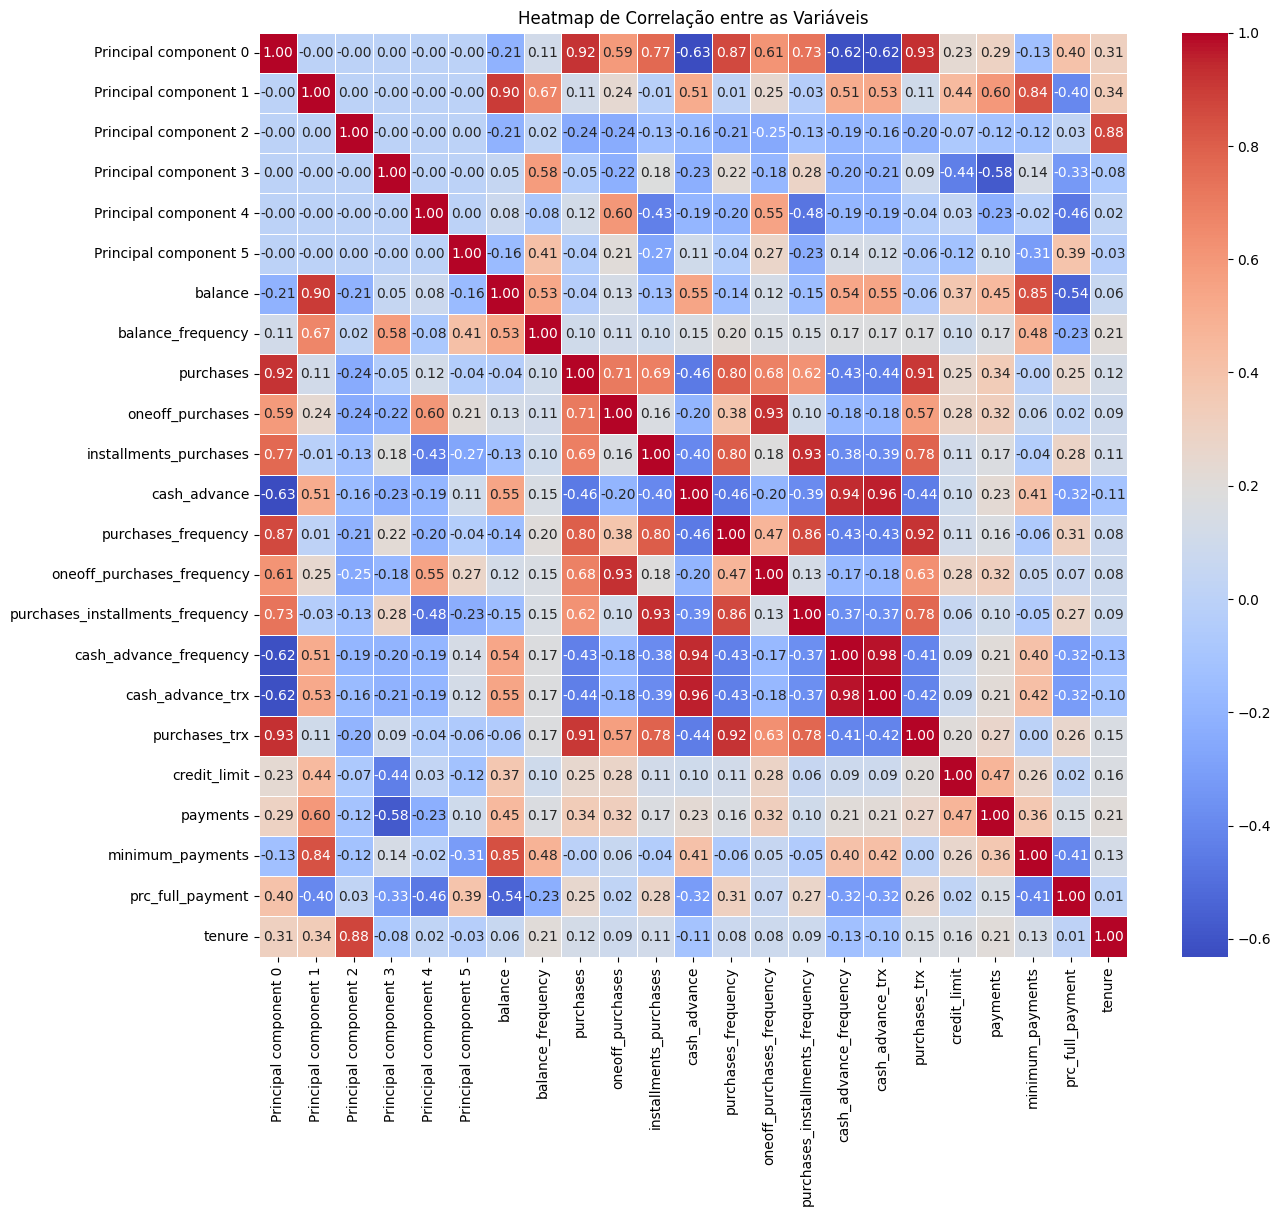

In [107]:
# Cálculo da matriz de correlação
correlation_matrix = PCA_finalDf.corr()

# Criação do gráfico de heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap de Correlação entre as Variáveis')
plt.show()


**OBS: Os componentes principais não possuem correlação**

Vamos considerar:

* Principal Component 0: Correlacionado diretamente com purchases, installments_purchases, purchases_frequency, purchases_installments_frequency, purchases_trx.

* Principal Component 1: Correlacionado diretamente com balance e minimum_payments.

* Principal Component 2: Correlacionado diretamente com tenure.

* Principal Component 3: Não tem boas correlações.

* Principal Component 4: Não tem boas correlações.

* Principal Component 5: Não tem boas correlações.

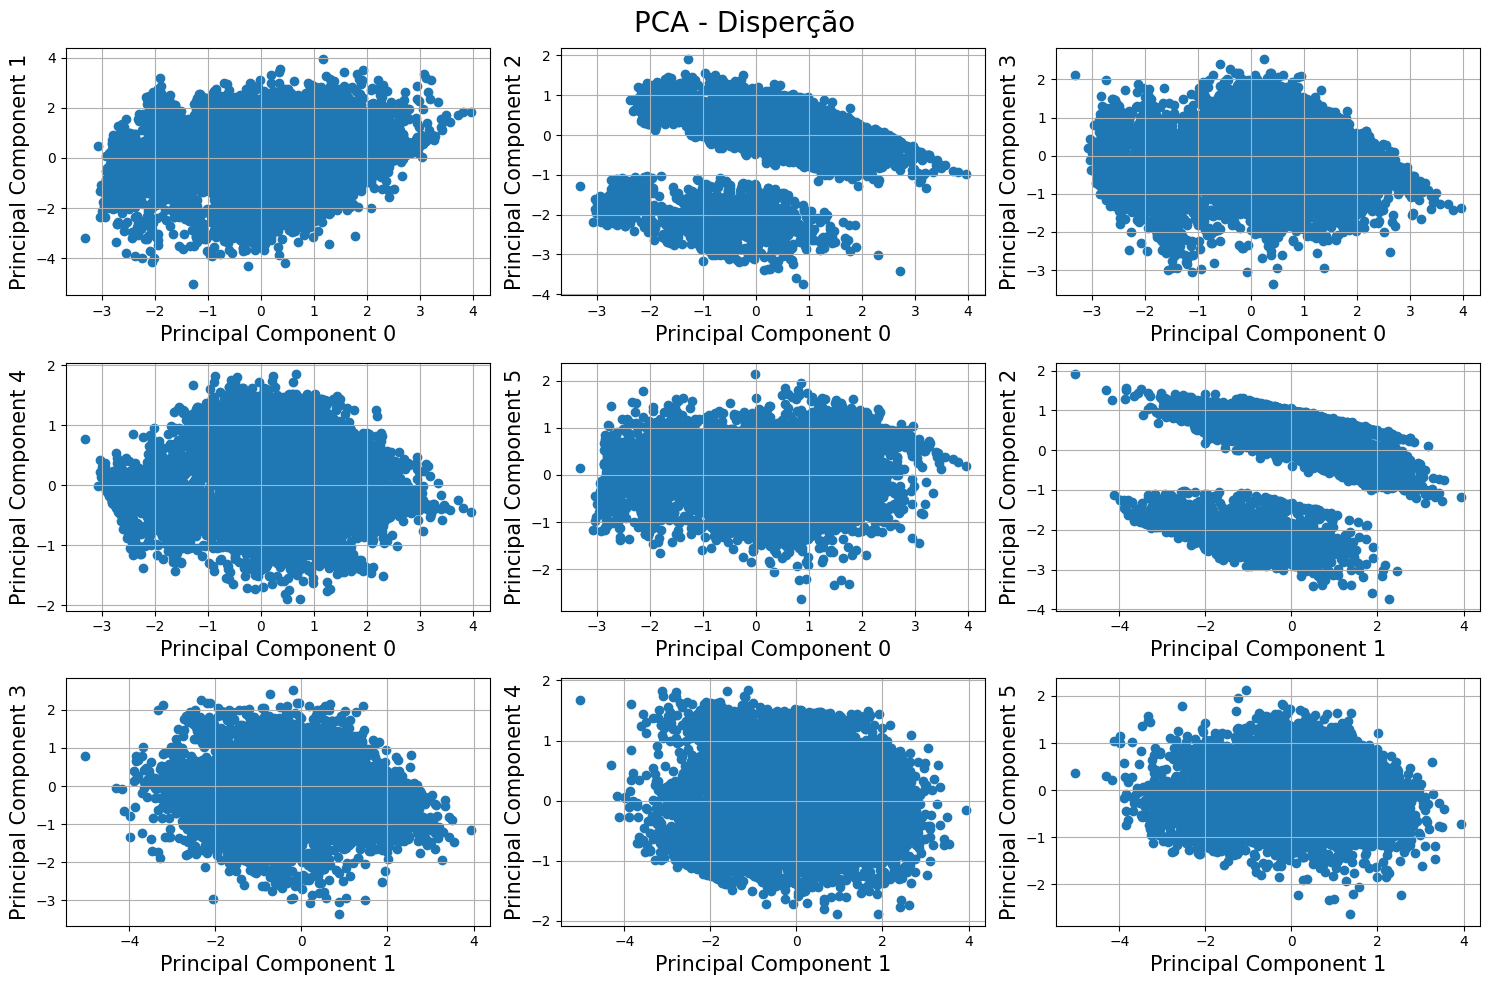

In [108]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Definição o gráfico 1
axs[0, 0].scatter(PCA_finalDf['Principal component 0'], PCA_finalDf['Principal component 1'])
axs[0, 0].set_xlabel('Principal Component 0', fontsize=15)
axs[0, 0].set_ylabel('Principal Component 1', fontsize=15)
axs[0, 0].grid()

# Definição o gráfico 2
axs[0, 1].scatter(PCA_finalDf['Principal component 0'], PCA_finalDf['Principal component 2'])
axs[0, 1].set_xlabel('Principal Component 0', fontsize=15)
axs[0, 1].set_ylabel('Principal Component 2', fontsize=15)
axs[0, 1].grid()

# Definição o gráfico 3
axs[0, 2].scatter(PCA_finalDf['Principal component 0'], PCA_finalDf['Principal component 3'])
axs[0, 2].set_xlabel('Principal Component 0', fontsize=15)
axs[0, 2].set_ylabel('Principal Component 3', fontsize=15)
axs[0, 2].grid()

# Definição o gráfico 4
axs[1, 0].scatter(PCA_finalDf['Principal component 0'], PCA_finalDf['Principal component 4'])
axs[1, 0].set_xlabel('Principal Component 0', fontsize=15)
axs[1, 0].set_ylabel('Principal Component 4', fontsize=15)
axs[1, 0].grid()

# Definição o gráfico 5
axs[1, 1].scatter(PCA_finalDf['Principal component 0'], PCA_finalDf['Principal component 5'])
axs[1, 1].set_xlabel('Principal Component 0', fontsize=15)
axs[1, 1].set_ylabel('Principal Component 5', fontsize=15)
axs[1, 1].grid()

# Definição o gráfico 6
axs[1, 2].scatter(PCA_finalDf['Principal component 1'], PCA_finalDf['Principal component 2'])
axs[1, 2].set_xlabel('Principal Component 1', fontsize=15)
axs[1, 2].set_ylabel('Principal Component 2', fontsize=15)
axs[1, 2].grid()

# Definição o gráfico 7
axs[2, 0].scatter(PCA_finalDf['Principal component 1'], PCA_finalDf['Principal component 3'])
axs[2, 0].set_xlabel('Principal Component 1', fontsize=15)
axs[2, 0].set_ylabel('Principal Component 3', fontsize=15)
axs[2, 0].grid()

# Definição o gráfico 8
axs[2, 1].scatter(PCA_finalDf['Principal component 1'], PCA_finalDf['Principal component 4'])
axs[2, 1].set_xlabel('Principal Component 1', fontsize=15)
axs[2, 1].set_ylabel('Principal Component 4', fontsize=15)
axs[2, 1].grid()

# Definição o gráfico 9
axs[2, 2].scatter(PCA_finalDf['Principal component 1'], PCA_finalDf['Principal component 5'])
axs[2, 2].set_xlabel('Principal Component 1', fontsize=15)
axs[2, 2].set_ylabel('Principal Component 5', fontsize=15)
axs[2, 2].grid()

fig.suptitle('PCA - Disperção', fontsize=20)

plt.tight_layout()

plt.show()

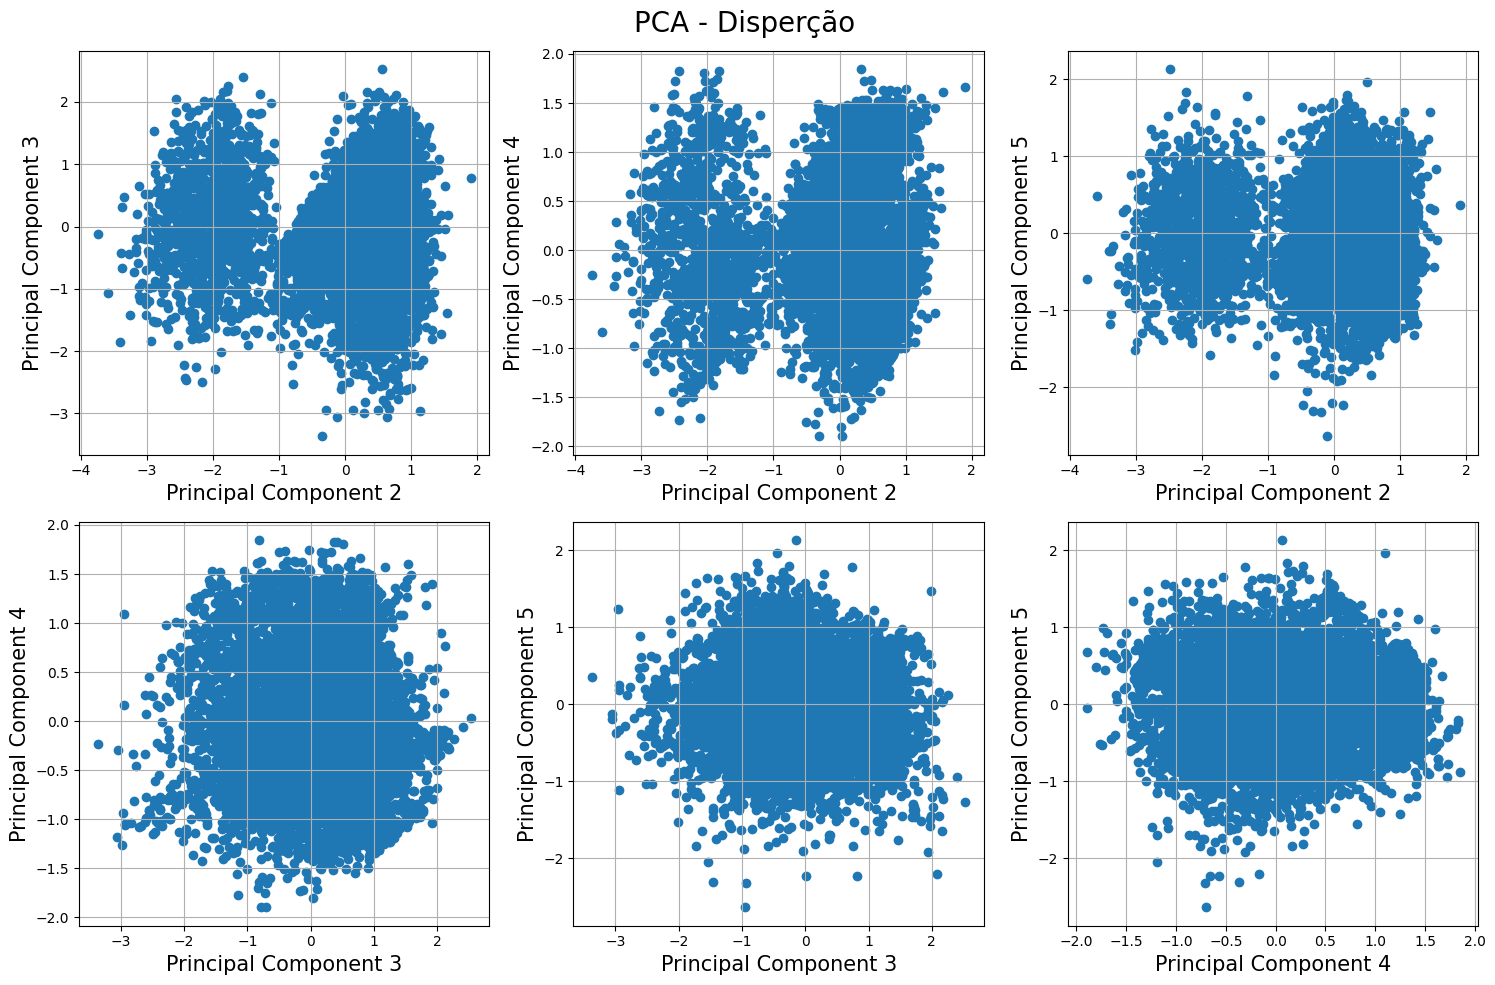

In [109]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Definição o gráfico 1
axs[0, 0].scatter(PCA_finalDf['Principal component 2'], PCA_finalDf['Principal component 3'])
axs[0, 0].set_xlabel('Principal Component 2', fontsize=15)
axs[0, 0].set_ylabel('Principal Component 3', fontsize=15)
axs[0, 0].grid()

# Definição o gráfico 2
axs[0, 1].scatter(PCA_finalDf['Principal component 2'], PCA_finalDf['Principal component 4'])
axs[0, 1].set_xlabel('Principal Component 2', fontsize=15)
axs[0, 1].set_ylabel('Principal Component 4', fontsize=15)
axs[0, 1].grid()

# Definição o gráfico 3
axs[0, 2].scatter(PCA_finalDf['Principal component 2'], PCA_finalDf['Principal component 5'])
axs[0, 2].set_xlabel('Principal Component 2', fontsize=15)
axs[0, 2].set_ylabel('Principal Component 5', fontsize=15)
axs[0, 2].grid()

# Definição o gráfico 4
axs[1, 0].scatter(PCA_finalDf['Principal component 3'], PCA_finalDf['Principal component 4'])
axs[1, 0].set_xlabel('Principal Component 3', fontsize=15)
axs[1, 0].set_ylabel('Principal Component 4', fontsize=15)
axs[1, 0].grid()

# Definição o gráfico 5
axs[1, 1].scatter(PCA_finalDf['Principal component 3'], PCA_finalDf['Principal component 5'])
axs[1, 1].set_xlabel('Principal Component 3', fontsize=15)
axs[1, 1].set_ylabel('Principal Component 5', fontsize=15)
axs[1, 1].grid()

# Definição o gráfico 6
axs[1, 2].scatter(PCA_finalDf['Principal component 4'], PCA_finalDf['Principal component 5'])
axs[1, 2].set_xlabel('Principal Component 4', fontsize=15)
axs[1, 2].set_ylabel('Principal Component 5', fontsize=15)
axs[1, 2].grid()


fig.suptitle('PCA - Disperção', fontsize=20)

plt.tight_layout()

plt.show()

# 6. Detecção de Anomalias

## 6.1 DBSCAN

Após reduzirmos a dimensionalidade da base de dados com o método PCA, aplicamos o algoritmo DBSCAN, um método poderoso para clusterização e detecção de anomalias. Para definir o melhor valor de `eps`, utilizamos um modelo de Nearest Neighbors para analisar a distância entre os pontos. Com base nessa análise, a melhor configuração encontrada foi um raio (eps) de 1.0, considerando os seis vizinhos mais próximos, correspondente ao número de variáveis escolhidas.

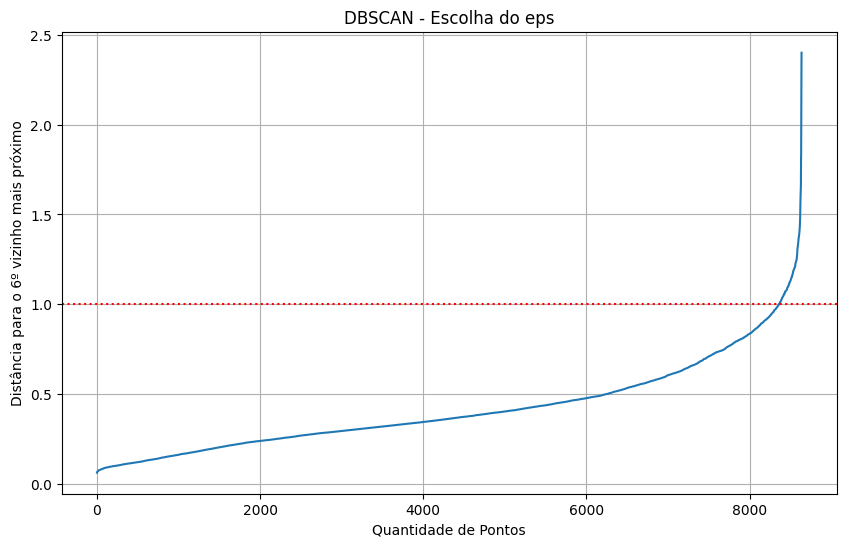

In [110]:
# Cálculo das distâncias para o min_samples nearest neighbors para cada ponto

dbscan = DBSCAN(eps=None, min_samples=6)  # Fixa o min_sample

neigh = NearestNeighbors(n_neighbors=dbscan.min_samples)
neigh.fit(PCA_finalDf.iloc[:,:6])
# cada valor de coluna representa a distância do ponto ao primeiro, segundo, terceiro,...,sexto vizinho mais próximo
distances, _ = neigh.kneighbors()

# Ordem das distâncias e plot do Knee Method curve
sorted_distances = sorted(distances[:, -1]) # distância para o sexto vizinho mais próximo
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_distances) + 1), sorted_distances)
plt.xlabel('Quantidade de Pontos')
plt.ylabel(f'Distância para o {dbscan.min_samples}º vizinho mais próximo')
plt.title('DBSCAN - Escolha do eps')
plt.grid(True)
plt.axhline(y=1, c='red', linestyle=':')
plt.show()

In [111]:
dbscan = DBSCAN(eps=1, min_samples=6)
dbscan_labels =  dbscan.fit_predict(PCA_finalDf.iloc[:,:6])

In [112]:
dbscan_labels.shape

(8636,)

In [113]:
dbscan_labels

array([ 0,  0,  0, ...,  1, -1,  1])

Após a aplicação do método de detecção de anomalias e clusterização DBSCAN, utilizando os seis componentes selecionados na redução de dimensionalidade pelo PCA, podemos observar nos gráficos, que combinam dois componentes por vez, como as anomalias estão distribuídas. O objetivo é visualizar essas distribuições em diferentes combinações de componentes para melhor compreender sua localização.

Podemos observar que as anomalias estão localizadas, em sua maioria, nos pontos extremos das distribuições em cada combinação.

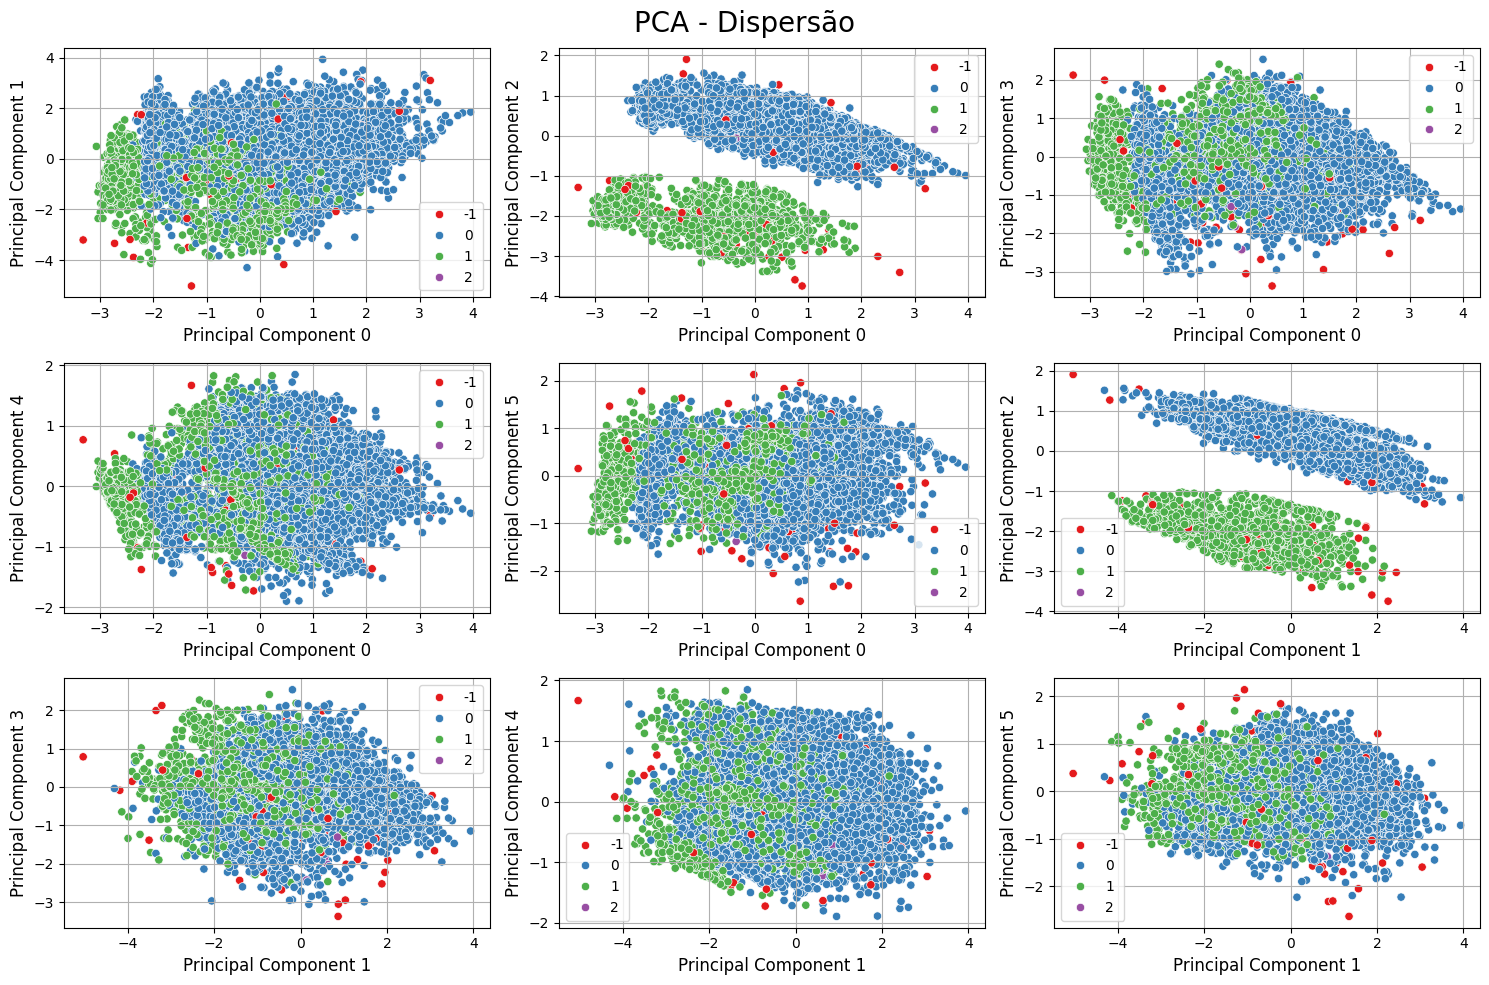

In [114]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Definindo os pares de componentes principais para os gráficos
pairs = [
    (0, 1), (0, 2), (0, 3),
    (0, 4), (0, 5), (1, 2),
    (1, 3), (1, 4), (1, 5)
]

# Iterando sobre os subgráficos e criando os scatter plots
for ax, (comp_x, comp_y) in zip(axs.flat, pairs):
    sns.scatterplot(x=PCA_finalDf[f'Principal component {comp_x}'],
                    y=PCA_finalDf[f'Principal component {comp_y}'],
                    hue=dbscan_labels, palette='Set1', ax=ax)
    
    ax.set_xlabel(f'Principal Component {comp_x}', fontsize=12)
    ax.set_ylabel(f'Principal Component {comp_y}', fontsize=12)
    ax.grid()

fig.suptitle('PCA - Dispersão', fontsize=20)

plt.tight_layout()
plt.show()


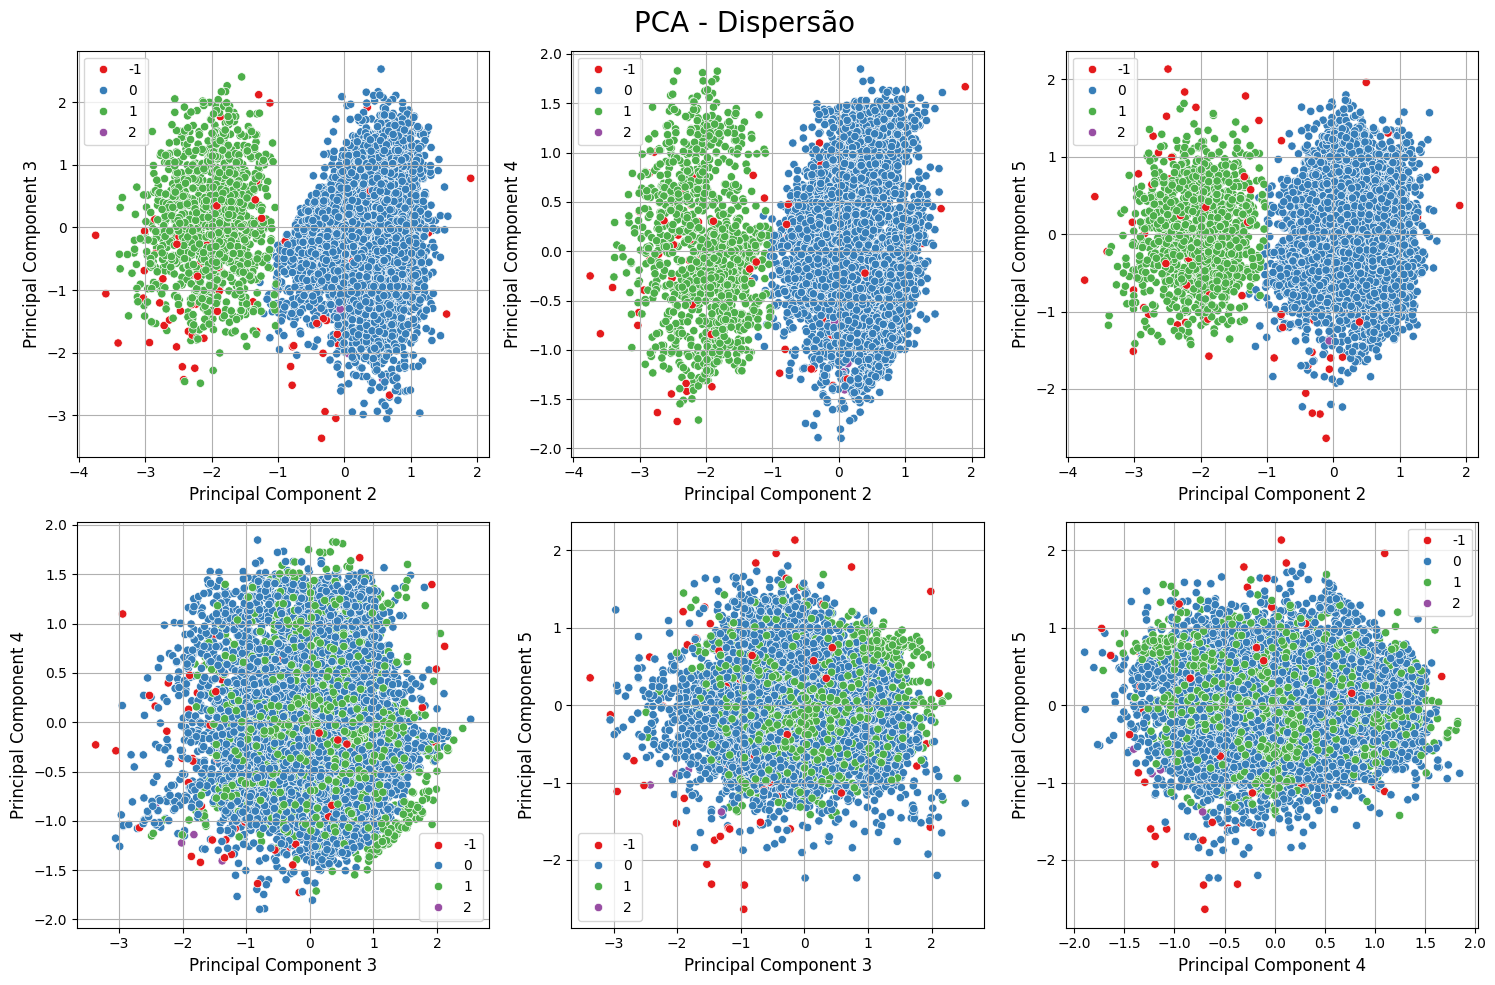

In [115]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Definindo os pares de componentes principais para os gráficos
pairs = [
    (2, 3), (2, 4), (2, 5),
    (3, 4), (3, 5), (4, 5)
]

# Iterando sobre os subgráficos e criando os scatter plots
for ax, (comp_x, comp_y) in zip(axs.flat, pairs):
    sns.scatterplot(x=PCA_finalDf[f'Principal component {comp_x}'],
                    y=PCA_finalDf[f'Principal component {comp_y}'],
                    hue=dbscan_labels, palette='Set1', ax=ax)
    
    ax.set_xlabel(f'Principal Component {comp_x}', fontsize=12)
    ax.set_ylabel(f'Principal Component {comp_y}', fontsize=12)
    ax.grid()

fig.suptitle('PCA - Dispersão', fontsize=20)

plt.tight_layout()
plt.show()


### 6.1.1 Resultado DBSCAN

O cluster anômalo se diferencia dos outros clusters pelos seguintes motivos:

* O cluster anômalo tem um valor médio de compras de **4.114,76 reais**, muito superior ao dos outros clusters (288,26, 484,53 e 1.085,86).

* O cluster anômalo tem compras únicas extremamente alto (2.593,73 reais), enquanto nos outros clusters são menores (0, 289,50 e 638,30).

*  O cluster anômalo tem compras parceladas elevado (1.521,32), bem acima dos outros clusters (288,26, 195,31 e 447,86).

* O cluster anômalo tem uma frequência (0,53) semelhante ao cluster 0 (0,50), mas maior do que o cluster 1 e 2 (0,399 e 0,41).

* A frequência de compras únicas é 0,27 no cluster anômalo, maior que a do cluster 0,1 e 2(0,21, 0,13 e 0).

* A frequência de adiantamento de dinheiro também é maior (0,22) do que a do cluster 0,1 e 2 (0,12, 0,20 e 0,21).

* O cluster anômalo tem um número muito maior de transações em compras (22,05) e maior apenas que o cluster 2 (11,47) em adiantamentos de dinheiro (7,47), enquanto os outros clusters têm valores menores.

* O cluster anômalo tem um limite de crédito médio de **8.080,52 reais**, maior que os outros clusters (3.290,17, 4.693,29 e 6.600).

* O cluster anômalo tem um valor médio de **2.179,53 reais**, significativamente superior aos outros clusters (906,31, 536,78 e 939,18) de pagamento mínimo.

* No cluster anômalo, o valor médio do percentual do pagamento total é 0,25, superior aos outros clusters (0,15, 0,16 e 0,16 ).

**O Cluster -1 pode ser considerado anômalo porque seus membros apresentam um padrão de comportamento muito diferente dos demais clusters**

In [116]:
df_credit_card['Cluster_dbscan'] = dbscan_labels
df_credit_card

cust_id   balance  balance_frequency  purchases  oneoff_purchases  \
0     C10001    40.901              0.818      95.40              0.00   
1     C10002  3202.467              0.909       0.00              0.00   
2     C10003  2495.149              1.000     773.17            773.17   
4     C10005   817.714              1.000      16.00             16.00   
5     C10006  1809.829              1.000    1333.28              0.00   
...      ...       ...                ...        ...               ...   
8943  C19184     5.872              0.500      20.90             20.90   
8945  C19186    28.494              1.000     291.12              0.00   
8947  C19188    23.399              0.833     144.40              0.00   
8948  C19189    13.458              0.833       0.00              0.00   
8949  C19190   372.708              0.667    1093.25           1093.25   

      installments_purchases  cash_advance  purchases_frequency  \
0                      95.40         0.000                0.167   
1                       0.00      6442.945                0.000   
2                       0.00         0.000                1.000   
4                       0.00         0.000                0.083   
5                    1333.28         0.000                0.667   
...                      ...           ...                  ...   
8943                    0.00         0.000                0.167   
8945                  291.12         0.000                1.000   
8947                  144.40         0.000                0.833   
8948                    0.00        36.559                0.000   
8949                    0.00       127.040                0.667   

      oneoff_purchases_frequency  purchases_installments_frequency  \
0                          0.000                             0.083   
1                          0.000                             0.000   
2                          1.000                             0.000   
4                          0.083                             0.000   
5                          0.000                             0.583   
...                          ...                               ...   
8943                       0.167                             0.000   
8945                       0.000                             0.833   
8947                       0.000                             0.667   
8948                       0.000                             0.000   
8949                       0.667                             0.000   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                      0.000                 0              2        1000.0   
1                      0.250                 4              0        7000.0   
2                      0.000                 0             12        7500.0   
4                      0.000                 0              1        1200.0   
5                      0.000                 0              8        1800.0   
...                      ...               ...            ...           ...   
8943                   0.000                 0              1         500.0   
8945                   0.000                 0              6        1000.0   
8947                   0.000                 0              5        1000.0   
8948                   0.167                 2              0         500.0   
8949                   0.333                 2             23        1200.0   

      payments  minimum_payments  prc_full_payment  tenure  Cluster_dbscan  
0      201.802           139.510             0.000      12               0  
1     4103.033          1072.340             0.222      12               0  
2      622.067           627.285             0.000      12               0  
4      678.335           244.791             0.000      12               0  
5     1400.058          2407.246             0.000      12               0  
...        ...               ...               ...     ... 

In [117]:
df_credit_card[df_credit_card['Cluster_dbscan']==2].describe()

balance  balance_frequency   purchases  oneoff_purchases  \
count     5.000000           5.000000    5.000000               5.0   
mean   1535.502600           0.672600  288.264000               0.0   
std     770.215981           0.176956  237.860663               0.0   
min     509.900000           0.364000   21.000000               0.0   
25%    1039.880000           0.727000   93.240000               0.0   
50%    1725.951000           0.727000  268.000000               0.0   
75%    1923.696000           0.727000  527.600000               0.0   
max    2478.086000           0.818000  531.480000               0.0   

       installments_purchases  cash_advance  purchases_frequency  \
count                5.000000      5.000000             5.000000   
mean               288.264000   4452.176800             0.399800   
std                237.860663   2538.388516             0.350702   
min                 21.000000      0.000000             0.083000   
25%                 93.240000   5074.475000             0.250000   
50%                268.000000   5326.343000             0.333000   
75%                527.600000   5465.142000             0.333000   
max                531.480000   6394.924000             1.000000   

       oneoff_purchases_frequency  purchases_installments_frequency  \
count                         5.0                          5.000000   
mean                          0.0                          0.350000   
std                           0.0                          0.325107   
min                           0.0                          0.083000   
25%                           0.0                          0.250000   
50%                           0.0                          0.250000   
75%                           0.0                          0.250000   
max                           0.0                          0.917000   

       cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
count                5.000000          5.000000       5.000000      5.000000   
mean                 0.216800         11.400000       9.800000   6600.000000   
std                  0.192058         20.549939       9.418068   2902.585055   
min                  0.000000          0.000000       1.000000   4500.000000   
25%                  0.083000          1.000000       4.000000   5000.000000   
50%                  0.167000          3.000000       7.000000   5000.000000   
75%                  0.417000          5.000000      12.000000   7000.000000   
max                  0.417000         48.000000      25.000000  11500.000000   

           payments  minimum_payments  prc_full_payment  tenure  \
count      5.000000          5.000000          5.000000     5.0   
mean   10218.319800        939.187800          0.163400    12.0   
std     7896.351394        578.589379          0.130978     0.0   
min     2999.461000        290.480000          0.000000    12.0   
25%     5293.609000        760.853000          0.091000    12.0   
50%     8167.083000        772.604000          0.143000    12.0   
75%    11480.874000       1008.777000          0.250000    12.0   
max    23150.572000       1863.225000          0.333000    12.0   

       Cluster_dbscan  
count             5.0  
mean              2.0  
std               0.0  
min               2.0  
25%               2.0  
50%               2.0  
75%               2.0  
max               2.0

In [118]:
df_credit_card[df_credit_card['Cluster_dbscan']==1].describe()

balance  balance_frequency    purchases  oneoff_purchases  \
count   1244.000000        1244.000000  1244.000000       1244.000000   
mean    1277.570417           0.842401   484.535651        289.500362   
std     1644.722213           0.206748   783.033123        644.354296   
min        0.127000           0.100000     0.000000          0.000000   
25%      100.070250           0.778000     0.000000          0.000000   
50%      777.531500           0.909000   193.115000          0.000000   
75%     1668.718750           1.000000   599.272500        285.302500   
max    15258.226000           1.000000  8335.690000       7400.850000   

       installments_purchases  cash_advance  purchases_frequency  \
count             1244.000000   1244.000000          1244.000000   
mean               195.314228   1340.532144             0.411497   
std                375.144754   2086.767626             0.391931   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.000000   
50%                  0.000000    348.367000             0.300000   
75%                239.827500   1890.310000             0.833000   
max               3431.000000  12702.428000             1.000000   

       oneoff_purchases_frequency  purchases_installments_frequency  \
count                 1244.000000                       1244.000000   
mean                     0.134616                          0.278588   
std                      0.223327                          0.351393   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.000000                          0.000000   
75%                      0.182000                          0.636000   
max                      1.000000                          1.000000   

       cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
count             1244.000000       1244.000000    1244.000000   1244.000000   
mean                 0.200360          4.238746       6.807878   3290.179528   
std                  0.244823          7.731001      11.047804   3042.058841   
min                  0.000000          0.000000       0.000000    150.000000   
25%                  0.000000          0.000000       0.000000   1200.000000   
50%                  0.125000          1.000000       4.000000   2000.000000   
75%                  0.333000          6.000000       9.000000   4000.000000   
max                  1.500000        110.000000     186.000000  30000.000000   

           payments  minimum_payments  prc_full_payment       tenure  \
count   1244.000000       1244.000000       1244.000000  1244.000000   
mean     972.269860        536.780129          0.160538     8.876206   
std     1497.298849       1099.716903          0.306875     1.793646   
min       16.385000          0.312000          0.000000     6.000000   
25%      231.266000        122.193000          0.000000     7.000000   
50%      474.348500        229.614500          0.000000     9.000000   
75%     1068.353750        559.994500          0.167000    11.000000   
max    19998.390000      18924.002000          1.000000    11.000000   

       Cluster_dbscan  
count          1244.0  
mean              1.0  
std               0.0  
min               1.0  
25%               1.0  
50%               1.0  
75%               1.0  
max               1.0

In [119]:
df_credit_card[df_credit_card['Cluster_dbscan']==0].describe()

balance  balance_frequency     purchases  oneoff_purchases  \
count   7311.000000        7311.000000   7311.000000       7311.000000   
mean    1648.071340           0.905235   1085.859791        638.307542   
std     2145.339561           0.205719   2148.297788       1665.088664   
min        0.000000           0.000000      0.000000          0.000000   
25%      156.313000           1.000000     55.705000          0.000000   
50%      944.851000           1.000000    417.000000         59.000000   
75%     2175.655000           1.000000   1247.590000        652.590000   
max    19043.139000           1.000000  41050.400000      40624.060000   

       installments_purchases  cash_advance  purchases_frequency  \
count             7311.000000   7311.000000          7311.000000   
mean               447.869255    910.517453             0.509995   
std                897.925647   2040.926706             0.401602   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083000   
50%                116.970000      0.000000             0.500000   
75%                530.020000    996.724000             1.000000   
max              15497.190000  47137.212000             1.000000   

       oneoff_purchases_frequency  purchases_installments_frequency  \
count                 7311.000000                       7311.000000   
mean                     0.217533                          0.384481   
std                      0.309197                          0.403913   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083000                          0.250000   
75%                      0.333000                          0.833000   
max                      1.000000                          1.000000   

       cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
count             7311.000000       7311.000000    7311.000000   7311.000000   
mean                 0.125897          3.107783      16.363425   4693.294323   
std                  0.190467          6.568768      26.319008   3655.732798   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1800.000000   
50%                  0.000000          0.000000       8.000000   3500.000000   
75%                  0.167000          4.000000      20.000000   6500.000000   
max                  1.000000        123.000000     358.000000  25000.000000   

           payments  minimum_payments  prc_full_payment  tenure  \
count   7311.000000       7311.000000       7311.000000  7311.0   
mean    1849.509426        906.311359          0.158099    12.0   
std     2800.705619       2486.204251          0.294145     0.0   
min        4.524000          0.038000          0.000000    12.0   
25%      470.699000        174.291500          0.000000    12.0   
50%      998.961000        328.151000          0.000000    12.0   
75%     2062.834000        871.193500          0.167000    12.0   
max    40627.595000      76406.208000          1.000000    12.0   

       Cluster_dbscan  
count          7311.0  
mean              0.0  
std               0.0  
min               0.0  
25%               0.0  
50%               0.0  
75%               0.0  
max               0.0

In [120]:
df_credit_card[df_credit_card['Cluster_dbscan']==-1].describe()

balance  balance_frequency     purchases  oneoff_purchases  \
count     76.000000          76.000000     76.000000         76.000000   
mean    2396.756263           0.788237   4114.767632       2593.735921   
std     3090.759321           0.244390   8111.702877       6612.118007   
min        0.000000           0.091000      0.000000          0.000000   
25%      279.441500           0.727000    295.570000          0.000000   
50%     1107.882500           0.875000    965.235000        136.000000   
75%     3055.206250           1.000000   2873.602500       1639.910000   
max    12323.845000           1.000000  49039.570000      40761.250000   

       installments_purchases  cash_advance  purchases_frequency  \
count               76.000000     76.000000            76.000000   
mean              1521.321184   3145.050763             0.537855   
std               3715.234971   5613.420716             0.358338   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.208250   
50%                152.920000    556.119500             0.545000   
75%                928.985000   4073.030500             0.875000   
max              22500.000000  27296.486000             1.000000   

       oneoff_purchases_frequency  purchases_installments_frequency  \
count                   76.000000                         76.000000   
mean                     0.265789                          0.341724   
std                      0.343947                          0.365906   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.091000                          0.202000   
75%                      0.500000                          0.678750   
max                      1.000000                          1.000000   

       cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
count               76.000000         76.000000      76.000000     76.000000   
mean                 0.229934          7.473684      22.052632   8080.526316   
std                  0.264174         15.573031      45.964884   6639.941344   
min                  0.000000          0.000000       0.000000    500.000000   
25%                  0.000000          0.000000       3.000000   2687.500000   
50%                  0.125000          2.000000       8.000000   6625.000000   
75%                  0.340750          7.750000      19.000000  11000.000000   
max                  1.000000        107.000000     347.000000  30000.000000   

           payments  minimum_payments  prc_full_payment     tenure  \
count     76.000000         76.000000         76.000000  76.000000   
mean    8268.343434       2179.536289          0.253855  10.223684   
std    10541.868422       4676.087205          0.320158   2.114071   
min        0.050000          0.019000          0.000000   6.000000   
25%      940.715250        101.956750          0.000000   8.750000   
50%     4306.769000        574.458500          0.105500  11.000000   
75%     9689.793250       1520.865500          0.466250  12.000000   
max    50721.483000      26378.908000          1.000000  12.000000   

       Cluster_dbscan  
count            76.0  
mean             -1.0  
std               0.0  
min              -1.0  
25%              -1.0  
50%              -1.0  
75%              -1.0  
max              -1.0

## 6.2 Isolation Forest

Após reduzirmos a dimensionalidade da base de dados com o método PCA, aplicamos o algoritmo Isolation Forest, um método poderoso para detecção de anomalias. Para definir o melhor valor do parâmetro contamination, testamos diferentes porcentagens, e o valor de 0,01 se mostrou eficaz nos resultados, indicando que aproximadamente 1% dos dados foram identificados como anômalos pelo modelo.

In [121]:
iso_forest = IsolationForest(contamination=0.01)  # Ajuste da porcentagem de contaminação conforme necessário

isolation_labels = iso_forest.fit_predict(PCA_finalDf.iloc[:,:6])

In [122]:
isolation_labels.shape

(8636,)

In [123]:
isolation_labels

array([ 1,  1,  1, ...,  1, -1,  1])

Após a aplicação do método de detecção de anomalias Isolation Forest, configurado para identificar aproximadamente 1% dos dados como anômalos, e utilizando os seis componentes selecionados na redução de dimensionalidade pelo PCA, podemos visualizar, por meio de gráficos combinando dois componentes por vez, como essas anomalias estão distribuídas. Observamos que, na maioria dos casos, as anomalias estão localizadas nos pontos extremos das distribuições em cada combinação de componentes.

Em comparação com o DBSCAN, o Isolation Forest tende a identificar anomalias em regiões mais extremas do espaço de características, enquanto o DBSCAN pode detectar agrupamentos mais densos de outliers.

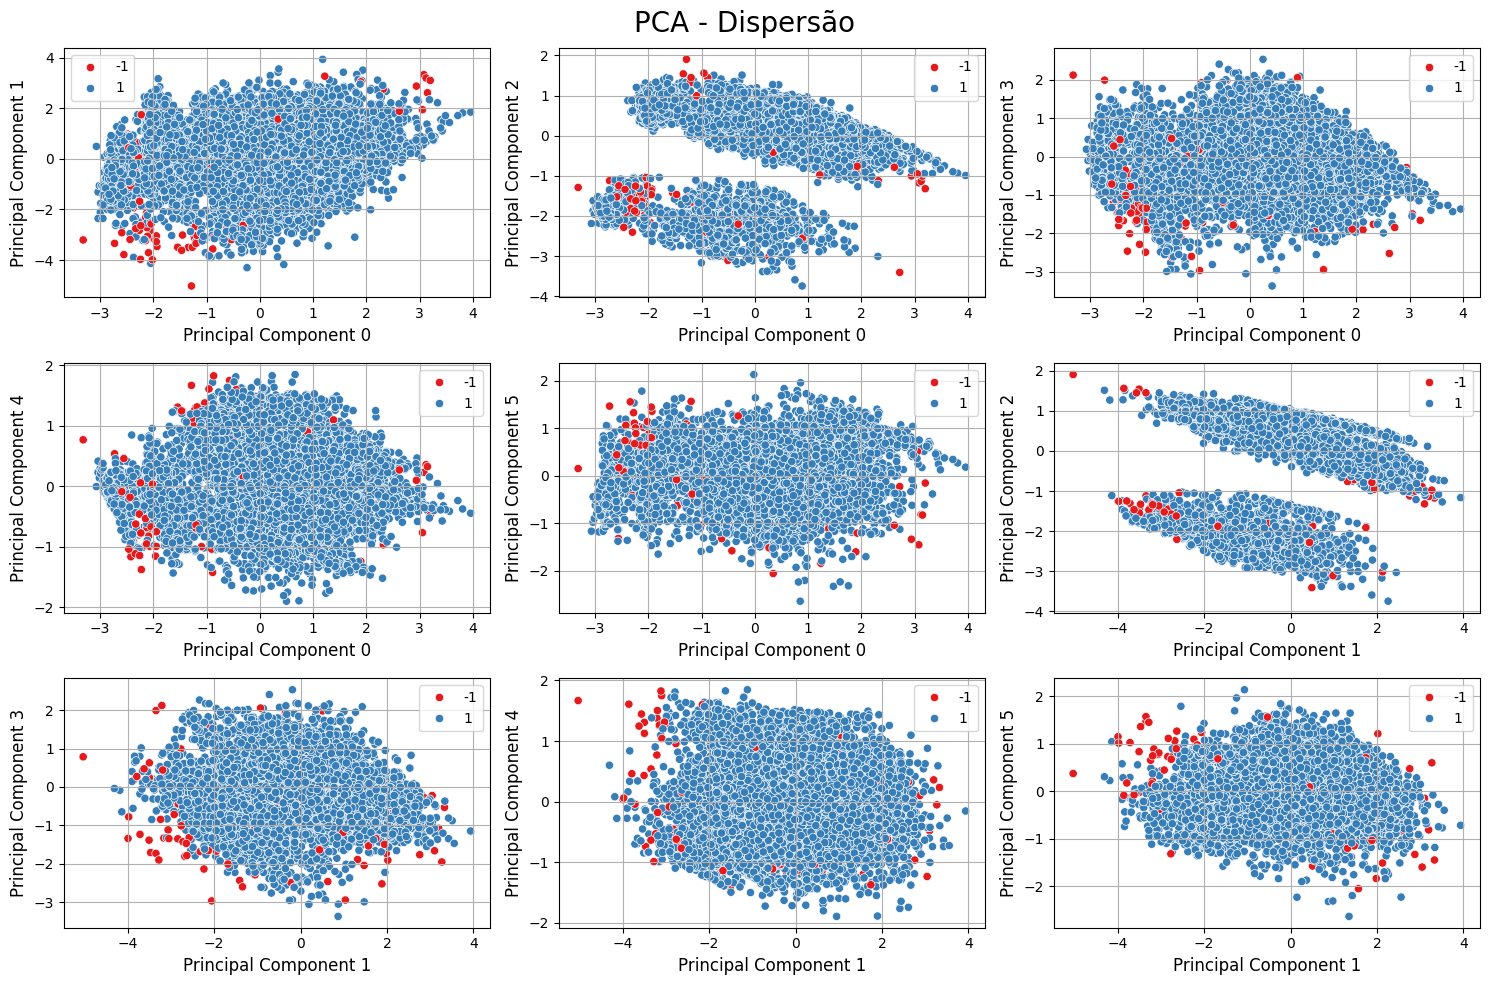

In [124]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Definindo os pares de componentes principais para os gráficos
pairs = [
    (0, 1), (0, 2), (0, 3),
    (0, 4), (0, 5), (1, 2),
    (1, 3), (1, 4), (1, 5)
]

# Iterando sobre os subgráficos e criando os scatter plots
for ax, (comp_x, comp_y) in zip(axs.flat, pairs):
    sns.scatterplot(x=PCA_finalDf[f'Principal component {comp_x}'],
                    y=PCA_finalDf[f'Principal component {comp_y}'],
                    hue=isolation_labels, palette='Set1', ax=ax)
    
    ax.set_xlabel(f'Principal Component {comp_x}', fontsize=12)
    ax.set_ylabel(f'Principal Component {comp_y}', fontsize=12)
    ax.grid()

fig.suptitle('PCA - Dispersão', fontsize=20)

plt.tight_layout()
plt.show()

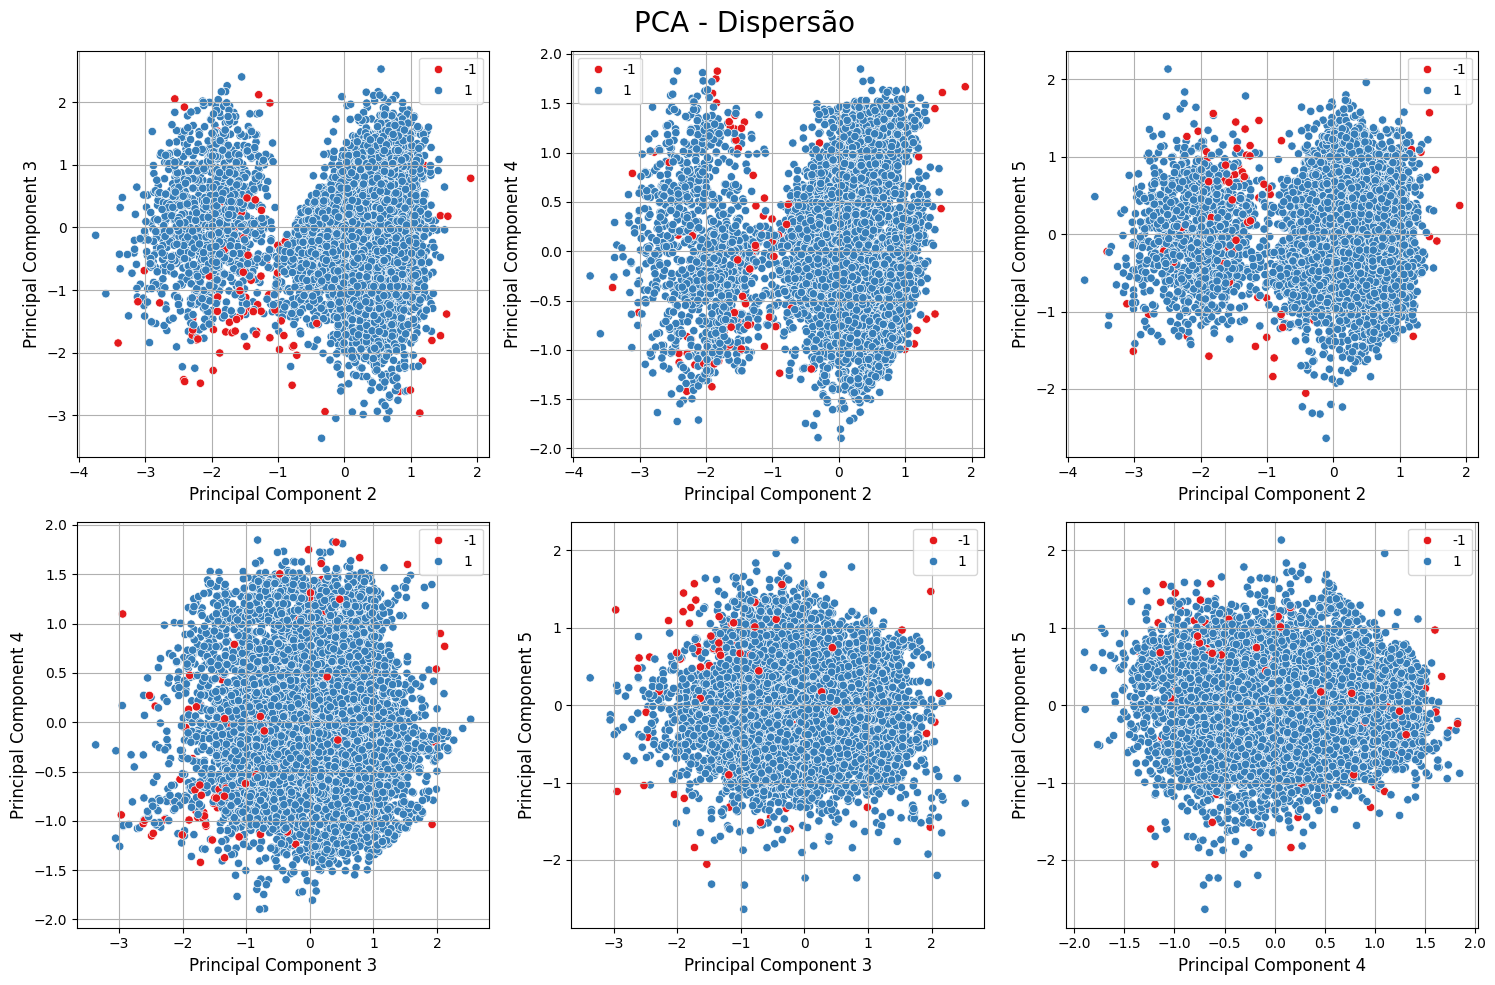

In [125]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Definindo os pares de componentes principais para os gráficos
pairs = [
    (2, 3), (2, 4), (2, 5),
    (3, 4), (3, 5), (4, 5)
]

# Iterando sobre os subgráficos e criando os scatter plots
for ax, (comp_x, comp_y) in zip(axs.flat, pairs):
    sns.scatterplot(x=PCA_finalDf[f'Principal component {comp_x}'],
                    y=PCA_finalDf[f'Principal component {comp_y}'],
                    hue=isolation_labels, palette='Set1', ax=ax)
    
    ax.set_xlabel(f'Principal Component {comp_x}', fontsize=12)
    ax.set_ylabel(f'Principal Component {comp_y}', fontsize=12)
    ax.grid()

fig.suptitle('PCA - Dispersão', fontsize=20)

plt.tight_layout()
plt.show()

### 6.2.1 Resultado Isolation Forest

Algumas características dos anômalos:

* Gastam muito mais (especialmente compras pontuais).

* Fazem menos compras, mas de alto valor.

* Usam mais adiantamentos de dinheiro.

* Têm um limite de crédito maior.

* Pagam valores mais altos e mais frequentemente a fatura completa.

* São clientes há menos tempo.

**De acordo com as descrições dos dados classificados como anômalos, a maioria das médias das características e os padrões observados diferem significativamente dos usuários em geral.**

In [126]:
df_credit_card['Cluster_IF'] = isolation_labels
df_credit_card

cust_id   balance  balance_frequency  purchases  oneoff_purchases  \
0     C10001    40.901              0.818      95.40              0.00   
1     C10002  3202.467              0.909       0.00              0.00   
2     C10003  2495.149              1.000     773.17            773.17   
4     C10005   817.714              1.000      16.00             16.00   
5     C10006  1809.829              1.000    1333.28              0.00   
...      ...       ...                ...        ...               ...   
8943  C19184     5.872              0.500      20.90             20.90   
8945  C19186    28.494              1.000     291.12              0.00   
8947  C19188    23.399              0.833     144.40              0.00   
8948  C19189    13.458              0.833       0.00              0.00   
8949  C19190   372.708              0.667    1093.25           1093.25   

      installments_purchases  cash_advance  purchases_frequency  \
0                      95.40         0.000                0.167   
1                       0.00      6442.945                0.000   
2                       0.00         0.000                1.000   
4                       0.00         0.000                0.083   
5                    1333.28         0.000                0.667   
...                      ...           ...                  ...   
8943                    0.00         0.000                0.167   
8945                  291.12         0.000                1.000   
8947                  144.40         0.000                0.833   
8948                    0.00        36.559                0.000   
8949                    0.00       127.040                0.667   

      oneoff_purchases_frequency  purchases_installments_frequency  \
0                          0.000                             0.083   
1                          0.000                             0.000   
2                          1.000                             0.000   
4                          0.083                             0.000   
5                          0.000                             0.583   
...                          ...                               ...   
8943                       0.167                             0.000   
8945                       0.000                             0.833   
8947                       0.000                             0.667   
8948                       0.000                             0.000   
8949                       0.667                             0.000   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                      0.000                 0              2        1000.0   
1                      0.250                 4              0        7000.0   
2                      0.000                 0             12        7500.0   
4                      0.000                 0              1        1200.0   
5                      0.000                 0              8        1800.0   
...                      ...               ...            ...           ...   
8943                   0.000                 0              1         500.0   
8945                   0.000                 0              6        1000.0   
8947                   0.000                 0              5        1000.0   
8948                   0.167                 2              0         500.0   
8949                   0.333                 2             23        1200.0   

      payments  minimum_payments  prc_full_payment  tenure  Cluster_dbscan  \
0      201.802           139.510             0.000      12               0   
1     4103.033          1072.340             0.222      12               0   
2      622.067           627.285             0.000      12               0   
4      678.335           244.791             0.000      12               0   
5     1400.058          2407.246             0.000      12               0   
...        ...               ...               ...   

In [127]:
df_credit_card['Cluster_IF'].value_counts()

Cluster_IF
 1    8549
-1      87
Name: count, dtype: int64

In [128]:
df_credit_card[df_credit_card['Cluster_IF']==-1].describe()

balance  balance_frequency     purchases  oneoff_purchases  \
count     87.000000          87.000000     87.000000         87.000000   
mean    2011.533368           0.599943   4162.273678       3078.648966   
std     3640.758963           0.292912   9679.189896       8155.172267   
min        0.000000           0.091000      0.000000          0.000000   
25%        7.202000           0.333000      0.000000          0.000000   
50%       86.794000           0.571000      0.000000          0.000000   
75%     2971.650000           0.889000    758.995000        310.655000   
max    19043.139000           1.000000  49039.570000      40761.250000   

       installments_purchases  cash_advance  purchases_frequency  \
count               87.000000     87.000000            87.000000   
mean              1083.624713   2430.438379             0.250092   
std               3184.404995   4580.225095             0.363725   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.000000   
50%                  0.000000    404.991000             0.000000   
75%                  0.000000   2032.682500             0.333000   
max              14686.100000  26194.050000             1.000000   

       oneoff_purchases_frequency  purchases_installments_frequency  \
count                   87.000000                         87.000000   
mean                     0.163322                          0.162690   
std                      0.268130                          0.338565   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.000000                          0.000000   
75%                      0.174500                          0.000000   
max                      1.000000                          1.000000   

       cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
count               87.000000         87.000000      87.000000     87.000000   
mean                 0.194310          6.149425      24.068966   5797.126437   
std                  0.235808         12.139239      60.397673   6381.260521   
min                  0.000000          0.000000       0.000000    300.000000   
25%                  0.000000          0.000000       0.000000   1200.000000   
50%                  0.111000          1.000000       0.000000   2500.000000   
75%                  0.250000          5.000000       7.000000   9000.000000   
max                  1.000000         69.000000     347.000000  30000.000000   

           payments  minimum_payments  prc_full_payment     tenure  \
count     87.000000         87.000000         87.000000  87.000000   
mean    7128.129448       1936.377149          0.316483   9.264368   
std    11340.226512       4838.981973          0.388272   2.315066   
min        0.050000          0.056000          0.000000   6.000000   
25%      201.341500         29.325000          0.000000   7.000000   
50%     1628.657000         70.412000          0.143000   9.000000   
75%     7742.727500       1027.658500          0.500000  12.000000   
max    50721.483000      26378.908000          1.000000  12.000000   

       Cluster_dbscan  Cluster_IF  
count       87.000000        87.0  
mean         0.356322        -1.0  
std          0.820904         0.0  
min         -1.000000        -1.0  
25%          0.000000        -1.0  
50%          1.000000        -1.0  
75%          1.000000        -1.0  
max          1.000000        -1.0

In [132]:
df_credit_card[df_credit_card['Cluster_IF']==1].describe()

balance  balance_frequency     purchases  oneoff_purchases  \
count   8549.000000        8549.000000   8549.000000       8549.000000   
mean    1597.049334           0.898022    993.511420        579.727028   
std     2073.891428           0.204474   1923.648298       1460.731241   
min        0.000000           0.000000      0.000000          0.000000   
25%      152.460000           0.909000     45.650000          0.000000   
50%      920.968000           1.000000    380.000000         45.650000   
75%     2097.471000           1.000000   1146.590000        600.000000   
max    18495.559000           1.000000  40040.710000      34087.730000   

       installments_purchases  cash_advance  purchases_frequency  \
count             8549.000000    8549.00000          8549.000000   
mean               414.098655     979.55921             0.498490   
std                862.185649    2077.04639             0.400901   
min                  0.000000       0.00000             0.000000   
25%                  0.000000       0.00000             0.083000   
50%                 98.000000       0.00000             0.500000   
75%                487.600000    1124.28400             0.917000   
max              22500.000000   47137.21200             1.000000   

       oneoff_purchases_frequency  purchases_installments_frequency  \
count                 8549.000000                       8549.000000   
mean                     0.206321                          0.370929   
std                      0.300362                          0.398131   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083000                          0.200000   
75%                      0.333000                          0.750000   
max                      1.000000                          1.000000   

       cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
count             8549.000000       8549.000000    8549.000000   8549.000000   
mean                 0.137014          3.285063      14.941280   4509.115467   
std                  0.201362          6.834020      24.555431   3619.381845   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.250000          4.000000      18.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           payments  minimum_payments  prc_full_payment       tenure  \
count   8549.000000       8549.000000       8549.000000  8549.000000   
mean    1730.097738        853.394866          0.157697    11.557492   
std     2639.272347       2332.158667          0.294791     1.276428   
min        9.533000          0.019000          0.000000     6.000000   
25%      419.352000        169.980000          0.000000    12.000000   
50%      892.893000        314.347000          0.000000    12.000000   
75%     1934.821000        823.904000          0.167000    12.000000   
max    40627.595000      76406.208000          1.000000    12.000000   

       Cluster_dbscan  Cluster_IF  
count     8549.000000      8549.0  
mean         0.134168         1.0  
std          0.361506         0.0  
min         -1.000000         1.0  
25%          0.000000         1.0  
50%          0.000000         1.0  
75%          0.000000         1.0  
max          2.000000         1.0

# 7. Comparaçao DBSCAN e Isolation Forest

In [142]:
anom_dbscan = df_credit_card[df_credit_card['Cluster_dbscan']==-1]['cust_id'].tolist()
anom_if = df_credit_card[df_credit_card['Cluster_IF']==-1]['cust_id'].tolist()

In [143]:
print(f'Foram detectados {len(anom_dbscan)} usuários como anômalos pelo DBSCAN')
print(f'Foram detectados {len(anom_if)} usuários como anômalos pelo Isolation Forest')

Foram detectados 76 usuários como anômalos pelo DBSCAN
Foram detectados 87 usuários como anômalos pelo Isolation Forest


In [148]:
print(f'Fazendo a interseção dos usuários obtidos com os dois modelos, foram detectados {len(set(anom_dbscan) & set(anom_if))} usuários que podem ser considerados suspeitos de fraudes e esses usuários são:')
set(anom_dbscan) & set(anom_if)

Fazendo a interseção dos usuários obtidos com os dois modelos, foram detectados 19 usuários que podem ser considerados suspeitos de fraudes e esses usuários são:


{'C10574',
 'C10767',
 'C11004',
 'C11310',
 'C11467',
 'C11576',
 'C11612',
 'C12868',
 'C13272',
 'C13319',
 'C13895',
 'C14338',
 'C15625',
 'C15875',
 'C17237',
 'C17476',
 'C17851',
 'C18969',
 'C19189'}